# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости, чтобы построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. 

## Цели и задачи исследования

                            
**Цель проекта:**
Выявить закономерности и факторы, влияющие на формирование стоимости квартиры

**Задачи проекта:**
- Установить, какие факторы (количество комнат, общая площадь, удаленность от центра и др.) в наибольшей степени влияют на стоимость квартиры;
- Выявить всплески и спады активности на рынке недвижимости в зависимости от дня недели и времени года;
- Обнаружить и объяснить другие закономерности, вытекающие из данных.


## Обзор и предобработка данных

### Общий обзор данных

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# считываем данные
try: 
    data = pd.read_csv('/datasets/real_estate_data.csv', sep ='\t')
except:
    data = pd.read_csv('/content/real_estate_data.csv', sep ='\t')
    

In [3]:
# общая информация о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
# сохраним количество строк в исходном датафрейме, чтобы сравнить после обработки
number_of_raw_data = 23699


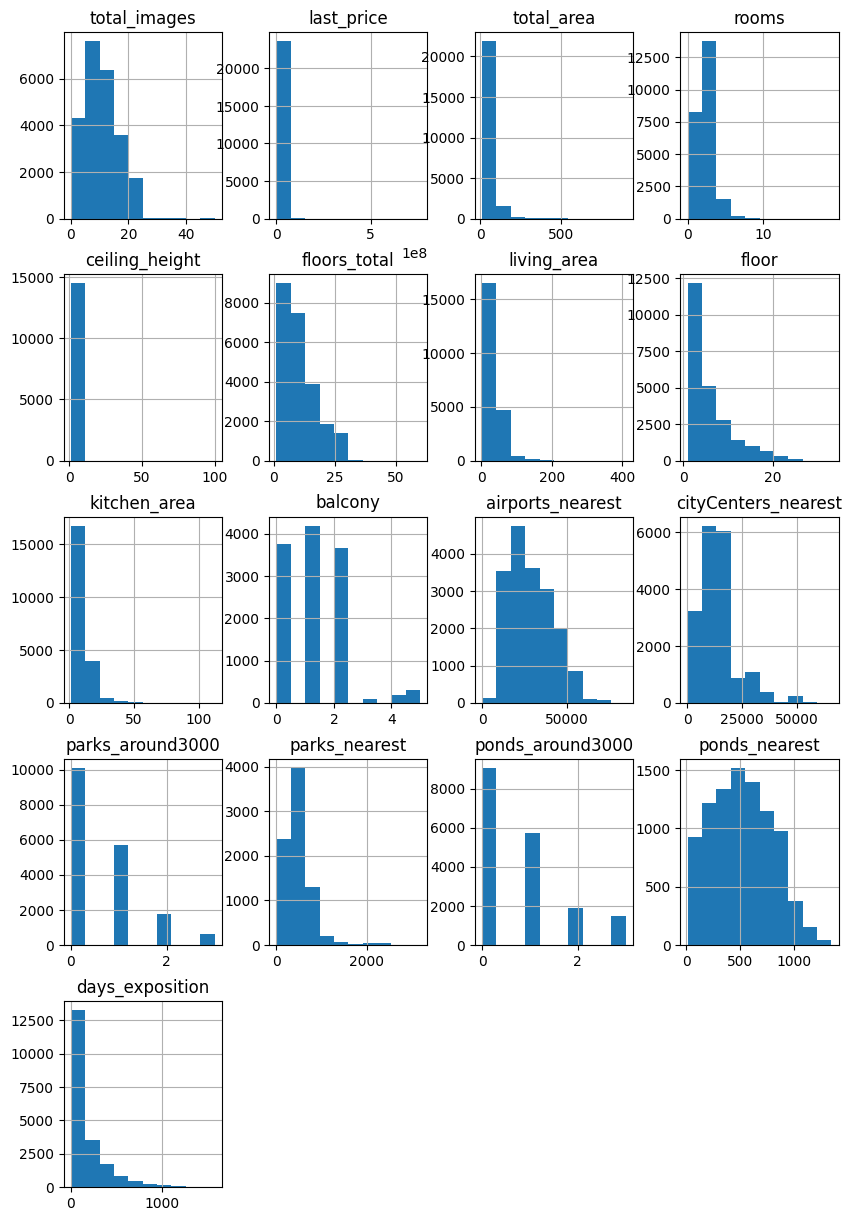

In [5]:
# смотрим на признаки на гистограммах
data.hist(figsize=(10,15));

### Предобработка данных

In [6]:
# смотрим, какие колонки есть в датафрейме
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [7]:
# переименовываем столбец cityCenters_nearest для единоообразия
data.rename(columns = {'cityCenters_nearest':'city_centers_nearest'}, inplace=True)
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

В столбцах есть данные, которые должны быть прямо связаны между собой. Так, общая площадь квартиры не может быть меньше, чем сумма площадей кухни и жилой зоны. Поэтому, чтобы определить, есть ли аномальные данные в этих столбцах, можно сравнить эти значения.

In [8]:
# делаем новый столбец, куда будет записано значение True, если общая площадь квартиры больше, 
# чем сумма жилой площади и кухни (коэффициент 0.9 — учет балкона, санузла и т. д.)
data['total_is_more'] = (
    (data['total_area'] * 0.9) >= (data['kitchen_area'] + data['living_area'])
                                )

# запишем значение в переменную, чтобы сравнить результат до и после предобработки данных
total_kit_liv_compare_before_processing = data['total_is_more'].value_counts()
total_kit_liv_compare_before_processing

True     20520
False     3179
Name: total_is_more, dtype: int64

Как видим, в ряде случаев общая площадь оказалась меньше, чем сумма площадей помещений в квартире. Возможно, часть значений в данных являются аномальными или же такой результат — следствие наличия пропусков в данных.

In [9]:
# пропуски в данных
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
total_is_more               0
dtype: int64

In [10]:
# пропуски на графике

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пропуски в данных' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('Пропусков не осталось :) ')

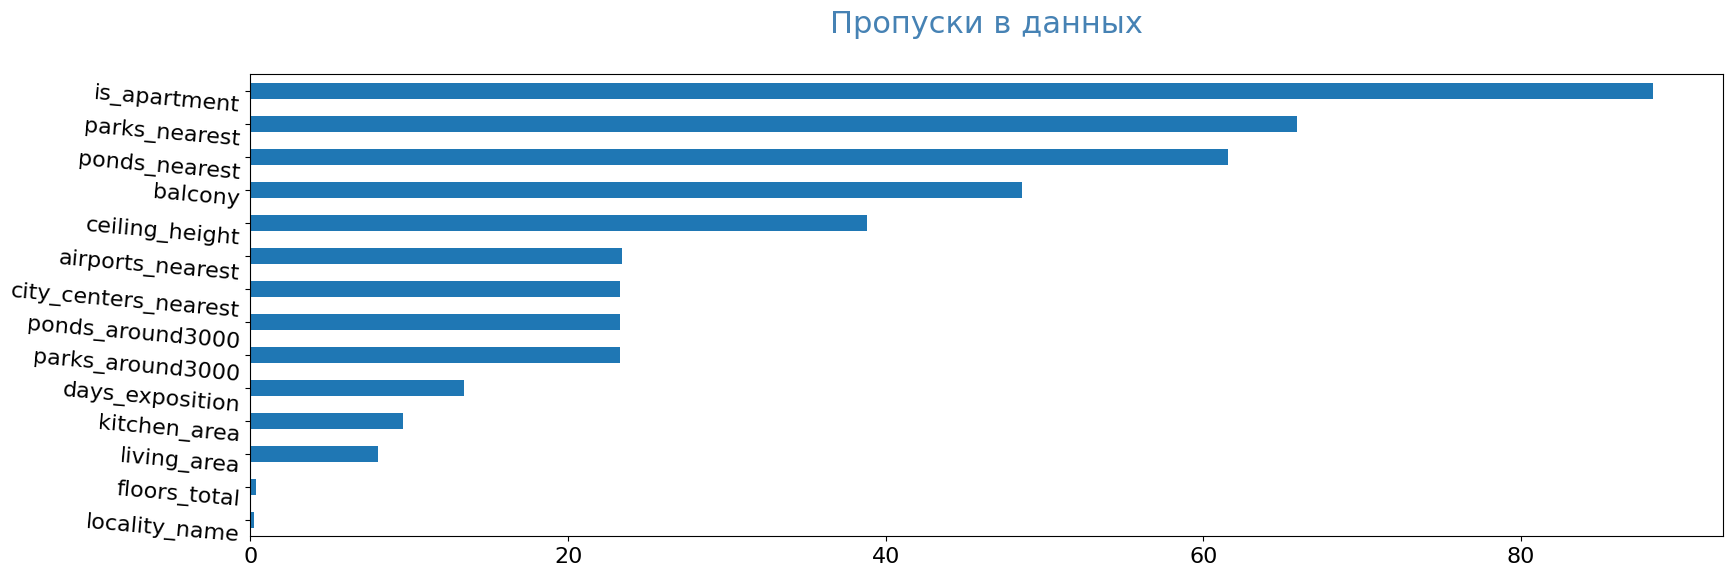

In [11]:
pass_value_barh(data)

В датафрейме много пропущенных данных. Столбцов без пропусков всего восемь, это: 
- `total_images` (число фотографий квартиры в объявлении), 
- `last_price` (цена квартиры на момент снятия объявления с публикации), 
- `total_area` (общая площадь квартиры в кв. м),
- `first_day_exposition` (дата публикации объявления), 
- `rooms` (число комнат в квартире), 
- `floor` (этаж, на котором расположена квартира),
- `studio` (квартира-студия), 
- `open_plan` (своободная планировка). 
Посмотрим на типы данных в столбцах.

In [12]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
city_centers_nearest    float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
total_is_more              bool
dtype: object

Изменим типы данных в столбцах: приведем данные в столбце `first_day_exposition` к типу _datetime_, а в столбце `is_apartment` — к типу _bool_ (по аналогии со столбцами `studio` и `open_plan`, так как содержащиеся в столбце значения являются логическими). 

In [13]:
# меняем тип данных на datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

# меняем тип данных на bool
data['is_apartment'] = data['is_apartment'].astype('bool')

# выводим обновленную информацию по типам данных
print(data.dtypes)

# еще раз смотрим на пропуски
data.isna().sum()



total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                        float64
locality_name                   object
airports_nearest               float64
city_centers_nearest           float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
total_is_more                     bool
dtype: object


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
total_is_more               0
dtype: int64

Посмотрим на уникальные значения в столбце `locality_name`, есть ли неявные дубликаты.

In [14]:
print(data['locality_name'].nunique())
data['locality_name'].unique()

364


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [15]:
# делаем новый столбец, где будут храниться обработанные данные по населенному пункту
data['locality_processed'] = data['locality_name']

# меняем некоторые значения, чтобы данные были более единообразными
data ['locality_processed'] = pd.DataFrame(data.locality_processed.str.replace('ё','е'))     
data ['locality_processed'] = pd.DataFrame(data.locality_processed.str.replace('поселок городского типа ',''))
data ['locality_processed'] = pd.DataFrame(data.locality_processed.str.replace('городской поселок ',''))
data ['locality_processed'] = pd.DataFrame(data.locality_processed.str.replace('поселок станции ',''))
data ['locality_processed'] = pd.DataFrame(data.locality_processed.str.replace('коттеджный поселок ',''))
data ['locality_processed'] = pd.DataFrame(data.locality_processed.str.replace('поселок при железнодорожной станции ',''))
data ['locality_processed'] = pd.DataFrame(data.locality_processed.str.replace('садовое товарищество ',''))
data ['locality_processed'] = pd.DataFrame(data.locality_processed.str.replace('садоводческое некоммерческое товарищество ',''))
data ['locality_processed'] = pd.DataFrame(data.locality_processed.str.replace('деревня ',''))
data ['locality_processed'] = pd.DataFrame(data.locality_processed.str.replace('село ',''))
data ['locality_processed'] = pd.DataFrame(data.locality_processed.str.replace('поселок ',''))

# смотрим, как изменились данные
data ['locality_processed'].nunique()

305

In [16]:
# удаляем строки с пропуском в столбце locality_processed
data.dropna(subset=['locality_processed'], inplace=True)

# проверяем, остались ли пропущенные значения в столбце
data['locality_processed'].isna().sum()

0

Пропуск в столбце, где содержится информация о количестве балконов, можно заменить на 0 (если не указано количество балконов, значит, вероятно, в квартире балкона нет).

In [17]:
# заменяем все пропуски в столбце balcony значением 0
data['balcony'] = data['balcony'].fillna(0)

Посмотрим на столбец, где содержится информация о высоте потолков (`ceiling_height`). 

In [18]:
# выводим список уникальных значений столбца ceiling_height
print(data['ceiling_height'].unique())

# смотрим на минимальное значение в столбце
print(data['ceiling_height'].min())

# смотрим на максимальное значение в столбце
print(data['ceiling_height'].max())

[  2.7     nan   3.03   2.5    2.67   2.56   3.05   2.75   2.6    2.9
   2.8    2.55   3.     2.65   3.2    2.61   3.25   3.45   2.77   2.85
   2.64   2.57   4.15   3.5    3.3    2.71   4.     2.47   2.73   2.84
   3.1    2.34   3.4    3.06   2.72   2.54   2.51   2.78   2.76  25.
   2.58   3.7    2.52   5.2    2.87   2.66   2.59   2.     2.45   3.6
   2.92   3.11   3.13   3.8    3.15   3.55   3.16   3.62   3.12   2.53
   2.74   2.96   2.46   5.3    5.     2.79   2.95   4.06   2.94   3.82
   3.54   3.53   2.83   4.7    2.4    3.38   3.01   5.6    3.65   3.9
   3.18   3.35   2.3    3.57   2.48   2.62   2.82   3.98   2.63   3.83
   3.52   3.95   3.75   2.88   3.67   3.87   3.66   3.85   3.86   4.19
   3.24   4.8    4.5    4.2    3.36  32.     3.08   3.68   3.07   3.37
   3.09   8.     3.26   3.34   2.81   3.44   2.97   3.14   4.37   2.68
   3.22   3.27  27.     4.1    2.93   3.46  24.     3.47   3.33   3.63
   3.32  26.     1.2    8.3    2.98   2.86   3.17   4.4    3.28   3.04
   4.45   5

Как видим, в столбце имеются аномальные значения (высота потолков 1 м, 100 м, более 20 м, от 5 до 20 м). Посчитаем, сколько всего строк с аномальными значениями в этом столбце.

In [19]:
# в ceiling_height указано значение 100
print(data[data['ceiling_height'] == 100] ['ceiling_height'].count())

# в ceiling_height указано значение больше 20
print(data[data['ceiling_height'] > 20] ['ceiling_height'].count())

# в ceiling_height указано значение меньше 1.5
print(data[data['ceiling_height'] <= 2] ['ceiling_height'].count())

# в ceiling_height указано значение от 6 до 20
print(data[(data['ceiling_height'] < 20) & (data['ceiling_height'] >= 5)] ['ceiling_height'].count())





1
22
14
14


Можно удалить строки со значениями 100 и меньше 2 в столбце `ceiling_height` (поскольку их незначительное количество) и обработать значения больше 20, разделив их на 10, поскольку, скорее всего, в этом случае просто сдвинута точка в числе. Что касается значений больше либо равно 5 м, но меньше 20 м, эти строки также лучше удалить, поскольку их также не много и непонятно, чем можно заменить эти значения.

In [20]:
# удаляем из датафрейма строки с аномальным значением в столбце ceiling_height
data = data.drop(data[(data['ceiling_height'] <= 2) | (data['ceiling_height'] >= 5) | 
                      (data['ceiling_height'] == 100.0) | (data['ceiling_height'] == 14.0) | 
                      (data['ceiling_height'] == 10.3)].index)

# значения более 20 м делим на 10
def ceiling_transform(ceiling):
    if ceiling >= 20:
        ceiling = ceiling/10
        return ceiling
    return ceiling

data['ceiling_height'] = data['ceiling_height'].apply(ceiling_transform)

# проверяем, остались ли аномальные значения
data['ceiling_height'].describe()

count    14439.000000
mean         2.725577
std          0.270275
min          2.200000
25%          2.520000
50%          2.650000
75%          2.800000
max          4.900000
Name: ceiling_height, dtype: float64

Явно аномальных значений в столбце не осталось. Заполним значения медианой по столбцу в зависимости от удаленности квартиры от центра в Санкт-Петербурге, поскольку квартиры в исторической части города могут иметь более высокие потолки, чем квартиры, удаленные от центра.


In [21]:
# посмотрим на диапазон значений в столбце city_centers_nearest
data['city_centers_nearest'].describe()

count    18108.000000
mean     14200.886790
std       8605.145418
min        181.000000
25%       9252.750000
50%      13107.000000
75%      16293.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

In [22]:
# сгруппируем данные по удаленности от центра
# будем считать, что радиус 7000 м — это центральная часть города

def city_center_type(city_centers_nearest):
    if 0.0 <= city_centers_nearest < 7000:
        return 'Центр'
    elif 7000 <= city_centers_nearest <= 10000:
        return 'До 3 км от центра'
    elif 10000 < city_centers_nearest <= 15000:
        return 'От 3 до 8 км от центра'
    elif 15000 < city_centers_nearest <= 20000:
        return 'Далеко от центра'
    elif 20000 < city_centers_nearest:
        return 'Окраина'
    else:
        return 'Определить не удалось'

# применяем функцию категоризации к новому столбцу
data['city_center_distance_spb'] = (data[data['locality_processed'] == "Санкт-Петербург"]
                                    ['city_centers_nearest'].apply(city_center_type))



In [23]:
# заполняем пропуски медианным значением 
# в зависимости от удаленности от центра для квартир в Санкт-Петербурге
for d in data['city_center_distance_spb'].unique():
        data.loc[(data['city_center_distance_spb'] == d) & (data['ceiling_height'].isna()), \
                 'ceiling_height'] = data.loc[(data['city_center_distance_spb'] == d), \
                                              'ceiling_height'].median()

# считаем, остались ли пропуски        
data['ceiling_height'].isna().sum()


3543

In [24]:
# заполняем оставшиеся пропуски медианой по столбцу
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

# считаем, остались ли пропуски
data['ceiling_height'].isna().sum()


0

In [25]:
# Проверяем, как изменились показатели
data['ceiling_height'].describe()

count    23599.000000
mean         2.701131
std          0.229506
min          2.200000
25%          2.600000
50%          2.600000
75%          2.750000
max          4.900000
Name: ceiling_height, dtype: float64

Посмотрим на уникальные значения в столбце `floors_total`, где также обнаружены пропуски, и выясним, есть ли там аномальные значения. Для этого нужно сравнить данные об этажности (`floors_total`) с номером этажа, где располагается квартира. Нужно, чтобы значение `floors_total` было больше, чем `floor`, либо равно ему.

In [26]:
# смотрим, есть ли в столбце явно аномальные значения
data['floors_total'].value_counts()

5.0     5755
9.0     3755
16.0    1372
12.0    1359
4.0     1192
10.0    1173
25.0    1074
6.0      908
17.0     831
3.0      664
7.0      588
14.0     551
18.0     504
24.0     461
8.0      387
2.0      377
15.0     364
23.0     349
19.0     339
22.0     286
20.0     271
13.0     229
11.0     202
27.0     164
21.0     158
26.0     124
1.0       25
35.0      24
28.0      21
36.0       2
34.0       1
60.0       1
29.0       1
33.0       1
52.0       1
Name: floors_total, dtype: int64

In [27]:
# добавляем столбец total_floors_ok, где будет значение True, 
# если общее количество этажей, указанное в таблице, 
# больше, чем номер этажа, на котором расположена квартира, или равно ему
data['total_floors_ok'] = data['floors_total'] >= data['floor']

# обрабатываем пропущенные значения в столбце floors_total —
# заполняем медианным значением в зависимости от значения в столбце с номером этажа
for d in data['floor'].unique():
        data.loc[(data['floor'] == d) & (data['floors_total'].isna()), 'floors_total'] = \
        data.loc[(data['floor'] == d), 'floors_total'].median()

# удаляем строки, где значение в столбце total_floors_ok — False
data = data.drop(data[data['total_floors_ok'] == False].index)

# считаем, остались ли аномальные значения и пропуски
print(data['total_floors_ok'].value_counts())
data['floors_total'].isna().sum()


True    23514
Name: total_floors_ok, dtype: int64


0

Аномальных значений в данных по этажам не обнаружено, пропуски мы заполнили медианой по квартирам, расположенным на аналогичном этаже.

Посмотрим на столбцы `living_area` и `kitchen_area`. Пропуски в них могут быть связаны с тем, что автор объявления просто не указал эти параметры. Очевидно, что эти показатели коррелируют с количеством комнат и общей площадью квартиры. Проверим.

In [28]:
# выводим данные о корреляции между столбцами
data.corr()

<ipython-input-28-ff904fe935ea>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_is_more,total_floors_ok
total_images,1.000000,0.103535,0.115369,0.098993,0.048168,0.009405,0.104389,0.032169,0.040491,-0.027404,...,0.046571,-0.002451,-0.047536,0.020773,-0.006129,-0.011534,-0.004552,-0.027811,0.092580,NaN
last_price,0.103535,1.000000,0.651992,0.362453,0.337060,-0.005680,0.563714,0.027172,-0.000208,-0.025352,...,0.008117,-0.026035,-0.206255,0.150309,-0.015723,0.161524,-0.086626,0.079905,-0.017541,NaN
total_area,0.115369,0.651992,1.000000,0.759289,0.447659,-0.074862,0.939584,-0.024412,-0.008702,-0.072682,...,0.010184,-0.030241,-0.231075,0.164700,-0.020159,0.164098,-0.101518,0.148620,0.003603,NaN
rooms,0.098993,0.362453,0.759289,1.000000,0.291404,-0.227848,0.846746,-0.151196,-0.005578,-0.145740,...,-0.015351,-0.061093,-0.184215,0.137410,-0.053672,0.094433,-0.060910,0.126048,0.046338,NaN
ceiling_height,0.048168,0.337060,0.447659,0.291404,1.000000,-0.123580,0.429783,-0.072839,-0.029797,-0.002726,...,-0.060845,-0.108555,-0.408468,0.261631,-0.050307,0.244675,-0.117742,0.130979,-0.014890,NaN
floors_total,0.009405,-0.005680,-0.074862,-0.227848,-0.123580,1.000000,-0.168744,0.678042,-0.005312,0.071007,...,0.173228,0.109054,0.018174,-0.252329,0.097172,-0.123536,0.040772,-0.052132,-0.035450,NaN
living_area,0.104389,0.563714,0.939584,0.846746,0.429783,-0.168744,1.000000,-0.096803,-0.009996,-0.057517,...,-0.015099,-0.057386,-0.230234,0.183938,-0.050548,0.150342,-0.083362,0.141746,-0.027534,NaN
floor,0.032169,0.027172,-0.024412,-0.151196,-0.072839,0.678042,-0.096803,1.000000,-0.008502,0.036186,...,0.171291,0.073183,0.008182,-0.163768,0.072937,-0.076389,0.026483,-0.038662,-0.016338,NaN
is_apartment,0.040491,-0.000208,-0.008702,-0.005578,-0.029797,-0.005312,-0.009996,-0.008502,1.000000,0.002791,...,-0.154888,0.007414,-0.002156,-0.001102,-0.019319,-0.009609,0.022113,-0.064232,-0.034003,NaN
studio,-0.027404,-0.025352,-0.072682,-0.145740,-0.002726,0.071007,-0.057517,0.036186,0.002791,1.000000,...,0.030601,-0.021321,-0.005752,-0.032386,0.008561,-0.001006,0.002606,-0.021259,-0.201950,NaN


Коэффициент корреляции между жилой площадью и значениями в колонках с количеством комнат и общей площадью близок к единице, следовательно, при заполнении пропусков в столбце `living_area` можно опираться на данные о площади квартир с аналогичным количеством комнат и аналогичной общей площадью. Пропусков в столбцах `rooms` и `total_area` в таблице нет.

Чтобы сгруппировать данные и заполнить пропуски в соответствии с этой группировкой, нужно, чтобы было не слишком большое количество уникальных значений. Посмотрим, сколько уникальных значений в столбцах `total_area` и `rooms`.

In [29]:
print(data['total_area'].nunique())
data['rooms'].nunique()

2154


17

В столбце `total_area` уникальных значений гораздо больше, чем в столбце `rooms`, при этом число уникальных значений в столбце с количеством комнат — 17 — позволяет сделать группировку по этому параметру и заполнить пропуски медианными значениями площади среди квартир с аналогичным количеством комнат. 

In [30]:
# заполняем пропущенные значения в столбце living_area
# медианой по значениям площади среди квартир с таким же количеством комнат
for d in data['rooms'].unique():
         data.loc[(data['rooms'] == d) & (data['living_area'].isna()), 'living_area'] = \
         data.loc[(data['rooms'] == d), 'living_area'].median()
    
# проверяем, остались ли пропущенные данные
data['living_area'].isna().sum()
    

0

Посмотрим, с какими значениями таблицы в наибольшей степени коррелирует площадь кухни. Для этого выведем матрицу корреляции.

In [31]:
data.corr()

<ipython-input-31-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_is_more,total_floors_ok
total_images,1.000000,0.103535,0.115369,0.098993,0.048168,0.009405,0.105770,0.032169,0.040491,-0.027404,...,0.046571,-0.002451,-0.047536,0.020773,-0.006129,-0.011534,-0.004552,-0.027811,0.092580,NaN
last_price,0.103535,1.000000,0.651992,0.362453,0.337060,-0.005680,0.553207,0.027172,-0.000208,-0.025352,...,0.008117,-0.026035,-0.206255,0.150309,-0.015723,0.161524,-0.086626,0.079905,-0.017541,NaN
total_area,0.115369,0.651992,1.000000,0.759289,0.447659,-0.074862,0.910369,-0.024412,-0.008702,-0.072682,...,0.010184,-0.030241,-0.231075,0.164700,-0.020159,0.164098,-0.101518,0.148620,0.003603,NaN
rooms,0.098993,0.362453,0.759289,1.000000,0.291404,-0.227848,0.853517,-0.151196,-0.005578,-0.145740,...,-0.015351,-0.061093,-0.184215,0.137410,-0.053672,0.094433,-0.060910,0.126048,0.046338,NaN
ceiling_height,0.048168,0.337060,0.447659,0.291404,1.000000,-0.123580,0.419702,-0.072839,-0.029797,-0.002726,...,-0.060845,-0.108555,-0.408468,0.261631,-0.050307,0.244675,-0.117742,0.130979,-0.014890,NaN
floors_total,0.009405,-0.005680,-0.074862,-0.227848,-0.123580,1.000000,-0.170504,0.678042,-0.005312,0.071007,...,0.173228,0.109054,0.018174,-0.252329,0.097172,-0.123536,0.040772,-0.052132,-0.035450,NaN
living_area,0.105770,0.553207,0.910369,0.853517,0.419702,-0.170504,1.000000,-0.098432,-0.010275,-0.057058,...,-0.010922,-0.056887,-0.225347,0.180397,-0.053403,0.146726,-0.084360,0.140154,-0.002352,NaN
floor,0.032169,0.027172,-0.024412,-0.151196,-0.072839,0.678042,-0.098432,1.000000,-0.008502,0.036186,...,0.171291,0.073183,0.008182,-0.163768,0.072937,-0.076389,0.026483,-0.038662,-0.016338,NaN
is_apartment,0.040491,-0.000208,-0.008702,-0.005578,-0.029797,-0.005312,-0.010275,-0.008502,1.000000,0.002791,...,-0.154888,0.007414,-0.002156,-0.001102,-0.019319,-0.009609,0.022113,-0.064232,-0.034003,NaN
studio,-0.027404,-0.025352,-0.072682,-0.145740,-0.002726,0.071007,-0.057058,0.036186,0.002791,1.000000,...,0.030601,-0.021321,-0.005752,-0.032386,0.008561,-0.001006,0.002606,-0.021259,-0.201950,NaN


Наибольшая корреляция у площади кухни — с общей площадью квартиры. Посчитаем уникальные значения в столбце `total_area`, чтобы понять, можно ли сгруппировать данные по этому стобцу.

In [32]:
data['total_area'].nunique()

2154


Уникальных значений слишком много. Заполним пропуски в `kitchen_area` медианой по столбцу и сравним медианные значения столбца до и после обработки.

In [33]:
# сохраняем в переменной медиану до предобработки
kitchen_median_before_processing = data['kitchen_area'].median()
kitchen_median_before_processing = 9.1

data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())
# выводим и сравниваем медиану до и после обработки
print(kitchen_median_before_processing)
print(data['kitchen_area'].median())
data['kitchen_area'].isna().sum()

9.1
9.1


0

Медианное значение по площади кухни после обработки не изменилось. Посмотрим, как изменилось количество аномальных значений в `total_area`, `kitchen_area` и `living_area`. Эти данные мы сохранили в переменную `total_kit_liv_compare_before_processing`.

In [34]:
# делаем столбец для вычисления аномальных данных (True — если общая площадь больше, 
# чем суммарное значение площади кухни и жилой площади, или равна ему)
data['total_is_more_after'] = (
    (data['total_area']*0.9) >= data['kitchen_area'] + data['living_area']
)
print(total_kit_liv_compare_before_processing)
data['total_is_more_after'].value_counts()

True     20520
False     3179
Name: total_is_more, dtype: int64


True     22450
False     1064
Name: total_is_more_after, dtype: int64

In [35]:
data[data['total_is_more_after'] == False][['total_area','kitchen_area','living_area']]

,total_area,kitchen_area,living_area
41,74.0,12.0,59.0
144,27.0,9.1,15.5
164,40.3,9.1,30.5
171,49.0,10.0,38.0
184,30.2,6.2,26.1
...,...,...,...
23592,29.0,9.1,18.0
23601,43.4,9.1,30.5
23613,52.0,9.1,45.0
23637,26.0,9.1,17.0


Значение изменилось, но аномальные данные еще есть. Удалим строки со значением False в этом столбце.

In [36]:
# удаляем строки, где значение в столбце total_is_more_after — False
data = data.drop(data[data['total_is_more_after'] == False].index)

# считаем, остались ли аномальные значения и пропуски
print(data['total_is_more_after'].value_counts())
data['kitchen_area'].isna().sum()


True    22450
Name: total_is_more_after, dtype: int64


0

Пропусков и аномальных значений не осталось. Пришлось удалить часть данных, чтобы анализ был более точным.

In [37]:
# еще раз посмотрим на число пропусков
data.isna().sum()

total_images                    0
last_price                      0
total_area                      0
first_day_exposition            0
rooms                           0
ceiling_height                  0
floors_total                    0
living_area                     0
floor                           0
is_apartment                    0
studio                          0
open_plan                       0
kitchen_area                    0
balcony                         0
locality_name                   0
airports_nearest             5123
city_centers_nearest         5100
parks_around3000             5099
parks_nearest               14728
ponds_around3000             5099
ponds_nearest               13792
days_exposition              3040
total_is_more                   0
locality_processed              0
city_center_distance_spb     7445
total_floors_ok                 0
total_is_more_after             0
dtype: int64

В столбце `days_exposition` обнаружены пропуски. Посмотрим на значения.

In [38]:
data['days_exposition'].describe()

count    19410.000000
mean       182.814271
std        221.204586
min          1.000000
25%         45.000000
50%         97.000000
75%        234.000000
max       1580.000000
Name: days_exposition, dtype: float64


В этом столбце большой разброс значений (об этом свидетельствует величина стандартного отклонения и значительная разница между медианой и средним). Возможно, наличие пропусков связано с тем, что квартира все еще находится в продаже. Пока оставим пропуски в этих данных.

Пропуски в столбцах, где указано количество парков и водоемов в радиусе 3 км, можно заполнить значением 0, поскольку, если не указано количество водоемов и парков, их в радиусе 3 км от кватиры, скорее всего, нет. Также в этих столбцах логично заменить тип данных на целые числа.

In [39]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')

Пропуски в столбцах `parks_nearest` и `ponds_nearest`, очевидно, связаны с отсутствием парков и водоемов поблизости от квартиры. Оставим эти пропуски.


Что касается данных в столбцах, содержащих информацию о расстоянии до ближайших аэропортов, то пропуски в них, вероятно, связаны с человеческим фактором. Оставим пропуски.

Расстояние до центра города необходимо рассматривать в соотношении с данными о населенном пункте.
Посмотрим, сколько пропусков в каждом из населенных пунктов. и попробуем предположить, с чем это связано.

In [40]:
# делаем таблицу из строк с пустыми значениями в столбце city_centers_nearest
data_center_is_null = data[data['city_centers_nearest'].isna()]

# считаем, в скольких наеленных пунктах пропущены значения в столбце city_centers_nearest
# и группируем значения по убыванию
print(data_center_is_null.groupby('locality_processed')['locality_processed']\
.count().sort_values(ascending=False))

# считаем, сколько пропусков в этом столбце приходится на Санкт-Петербург
spb_center_is_null = (
    data_center_is_null[data_center_is_null['locality_processed']=="Санкт-Петербург"]\
     ['locality_processed'].count()
)
print()
print(f'Пропусков в столбце city_centers_nearest в Санкт-Петербурге: {spb_center_is_null}')

locality_processed
Мурино                     508
Кудрово                    418
Всеволожск                 373
Гатчина                    298
Выборг                     216
                          ... 
Платформа 69-й километр      1
Пикколово                    1
Пижма                        1
Пельгора                     1
Пустынка                     1
Name: locality_processed, Length: 281, dtype: int64

Пропусков в столбце city_centers_nearest в Санкт-Петербурге: 58


Большая часть пропусков приходится не на Санкт-Петербург, а на другие города, где, возможно, близость к центру — не такой важный параметр, как в Петербурге. Пока оставим пропуски в этом столбце.

Еще раз посмотрим на типы данных в датафрейме.

In [41]:
data.dtypes

total_images                         int64
last_price                         float64
total_area                         float64
first_day_exposition        datetime64[ns]
rooms                                int64
ceiling_height                     float64
floors_total                       float64
living_area                        float64
floor                                int64
is_apartment                          bool
studio                                bool
open_plan                             bool
kitchen_area                       float64
balcony                            float64
locality_name                       object
airports_nearest                   float64
city_centers_nearest               float64
parks_around3000                     int64
parks_nearest                      float64
ponds_around3000                     int64
ponds_nearest                      float64
days_exposition                    float64
total_is_more                         bool
locality_pr

Сменим тип данных в столбце `floors_total`.

In [42]:
data['floors_total'] = data['floors_total'].astype('int')
data['floors_total'].dtypes

dtype('int64')



Проверим, какие аномалии остались в колонках.

In [43]:
data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 
      'last_price', 'living_area',  'kitchen_area',
      'floor', 'floors_total']].describe()


,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,22450.000000,22450.000000,22450.000000,19410.000000,2.245000e+04,22450.000000,22450.000000,22450.000000,22450.000000
mean,2.083029,60.793856,2.700869,182.814271,6.572887e+06,34.154758,10.353249,5.865924,10.650824
std,1.064310,35.494030,0.229399,221.204586,1.091178e+07,21.321306,5.426007,4.838091,6.539571
min,0.000000,18.000000,2.250000,1.000000,1.219000e+04,2.000000,1.300000,1.000000,1.000000
25%,1.000000,40.500000,2.600000,45.000000,3.500000e+06,18.400000,7.200000,2.000000,5.000000
50%,2.000000,52.200000,2.600000,97.000000,4.695000e+06,30.300000,9.100000,4.000000,9.000000
75%,3.000000,70.000000,2.750000,234.000000,6.800000e+06,42.300000,11.500000,8.000000,16.000000
max,19.000000,900.000000,4.900000,1580.000000,7.630000e+08,409.700000,112.000000,33.000000,60.000000


Некоторые значения в выведенных столбцах демонстрируют сильное отклонение от среднего и медианы. Эти значения не являются невозможными, однако в рамках нашей разнородной выборки они могут искажать результаты исследования и средние показатели по выборке. Избавимся от значений с наиболее значительным отклонением. 

In [44]:

# смотрим, сколько квартир с аномальными значениями
data.rooms.value_counts().to_frame()

,rooms
2,7657
1,7635
3,5536
4,1105
5,303
6,94
7,58
0,32
8,11
9,8


In [45]:
# значения количества комнат на разных квантилях
data['rooms'].quantile([.25, .5, .75, .99])


0.25    1.0
0.50    2.0
0.75    3.0
0.99    5.0
Name: rooms, dtype: float64

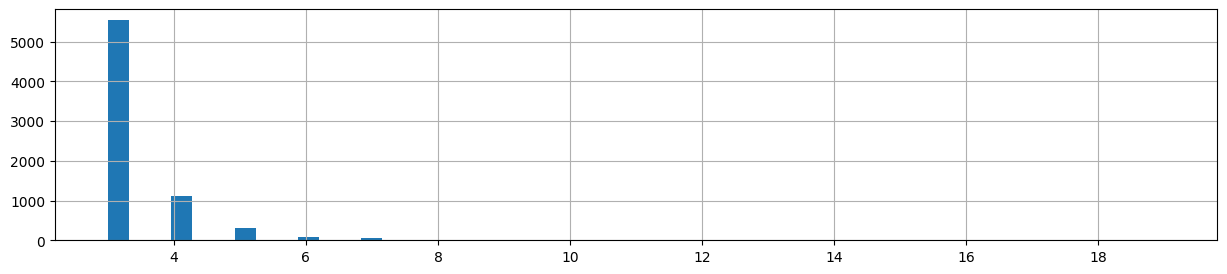

In [46]:
data['rooms'].hist(range=(3,19), bins=50, figsize=(15,3));

Как видим, квартиры с количеством комнат более 5 составляют менее 1% от выборки, в то время как 1, 2 и 3 комнаты четко делаят выборку на квартили. Чтобы выбивающиеся значения не искажали средние данные, их придется удалить. В качестве границы возьмем 5 комнат.

In [47]:
data = data.drop(data[data['rooms'] > 5].index)
data['rooms'].describe()

count    22268.000000
mean         2.042932
std          0.957276
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rooms, dtype: float64


Значение 0 в столбце с числом комнат может быть связано с тем, что это квартиры-студии или квартиры свободной планировки. Проверим.

In [48]:
# делаем датафрейм, где будут только те квартиры, у которых указано нулевое число комнат
data_0_rooms = data[data['rooms'] == 0]

# считаем, сколько среди таких квартир — студии
studios_0_rooms = data_0_rooms[data_0_rooms['studio'] == True]['studio'].sum()
print(f'Квартир-студий с 0 комнат: {studios_0_rooms}')

# считаем, сколько среди таких квартир — квартиры свободной планировки
open_plan_0_rooms = data_0_rooms[data_0_rooms['open_plan'] == True]['open_plan'].sum()
print(f'Квартир свободной планировки с 0 комнат: {open_plan_0_rooms}')

# считаем, сколько всего квартир с 0 комнат
total_0_rooms = len(data_0_rooms)
print(f'Квартир с 0 комнат всего: {total_0_rooms}')

Квартир-студий с 0 комнат: 24
Квартир свободной планировки с 0 комнат: 8
Квартир с 0 комнат всего: 32



Получается, что все квартиры, у которых указано 0 комнат, являются либо студиями, либо квартирами свободной планировки.


Посмотрим, сколько всего квартир свободной планировки и студий было в исходном датафрейме.

In [49]:
studios_total = data[data['studio']==True]['studio'].sum()
print(f'Квартир-студий всего: {studios_total}')

open_plan_total = data[data['open_plan'] == True]['open_plan'].sum()
print(f'Квартир свободной планировки всего: {open_plan_total}')


Квартир-студий всего: 25
Квартир свободной планировки всего: 15



Как видим, у большей части студий и квартир свободной планировки указано 0 в столбце `rooms`. Вероятно, значение 0 в столбце с числом комнат связано с особенностями планировки квартиры. Значит, это значение мы не будем считать аномальным и удалять.

Посмотрим, какие аномальные значения есть в столбце `total_area`.

In [50]:
data['total_area'].describe()

count    22268.000000
mean        59.304456
std         29.824419
min         18.000000
25%         40.400000
50%         52.000000
75%         69.200000
max        507.000000
Name: total_area, dtype: float64

In [51]:
# распределение значений total_area по квантилям

data['total_area'].quantile([.05, .5, .75, .85, .90, .95, .99])

0.05     31.20
0.50     52.00
0.75     69.20
0.85     80.80
0.90     91.73
0.95    111.00
0.99    170.00
Name: total_area, dtype: float64

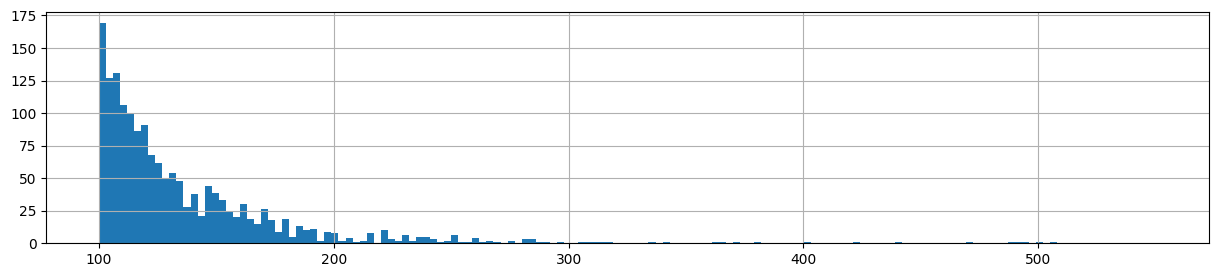

In [52]:
data.total_area.hist(figsize=(15,3), range=(100, 550), bins=150);


Можно удалить значения более 200 кв. м, поскольку они сильно отклоняются от среднего, в процентном отношении их немного (менее 1%), а в результате средние данные не будут сильно искажены. После удаления посмотрим, как изменились статистические показатели в столбце.

In [53]:
data = data.drop(data[data['total_area']>=200].index)
data['total_area'].describe()

count    22158.00000
mean        58.28201
std         25.61356
min         18.00000
25%         40.30000
50%         52.00000
75%         69.00000
max        199.20000
Name: total_area, dtype: float64


Как видим, значение стандартного отклонения и разница между средним и медианой уменьшились, а значит, распределение данных стало более равномерным.


Посмотрим, какие аномальные значения остались в столбце с высотой потолков.

In [54]:
data['ceiling_height'].describe()

count    22158.000000
mean         2.694422
std          0.218543
min          2.250000
25%          2.600000
50%          2.600000
75%          2.750000
max          4.800000
Name: ceiling_height, dtype: float64

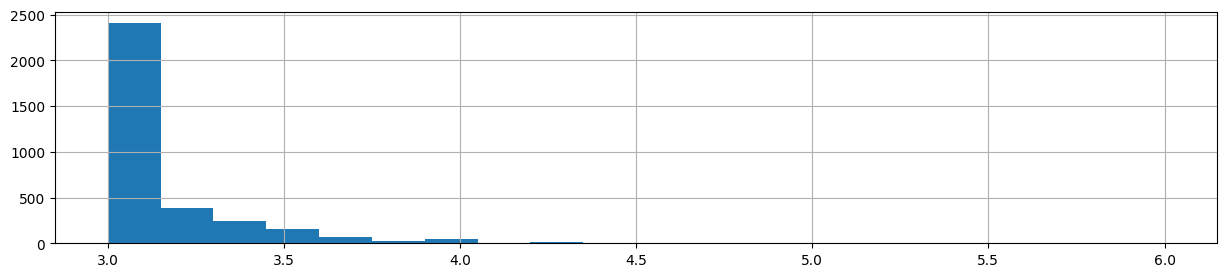

In [55]:
data['ceiling_height'].hist(figsize=(15,3), bins=20,range=(3,6));

Удалим значения более 4.2 м, поскольку их немного и такие квартиры встречаются в старых домах (согласно данным из интернета). И сравним статистические показатели после обработки.

In [56]:
data = data.drop(data[data['ceiling_height'] > 4.2].index)
data['ceiling_height'].describe()

count    22149.000000
mean         2.693705
std          0.215655
min          2.250000
25%          2.600000
50%          2.600000
75%          2.750000
max          4.200000
Name: ceiling_height, dtype: float64

Посмотрим на столбец `days_exposition`.

In [57]:
data['days_exposition'].describe()

count    19188.000000
mean       181.382427
std        219.551933
min          1.000000
25%         45.000000
50%         97.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

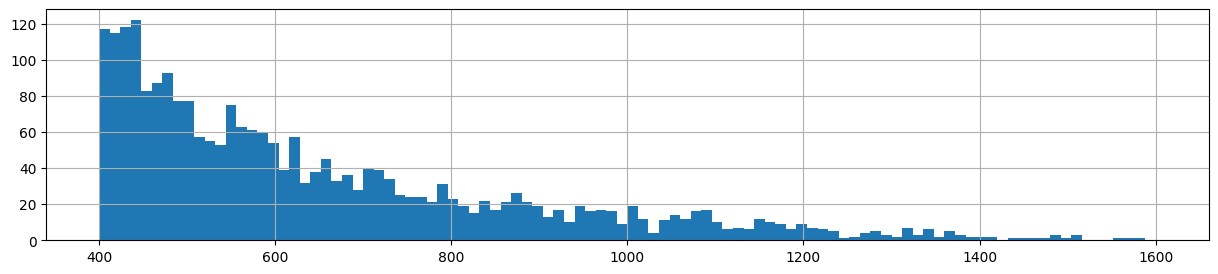

In [58]:
data.days_exposition.hist(figsize=(15,3), bins=100, range=(400,1600));

В столбце есть значения, которые сильно выбиваются из общего ряда. Мы обработаем их позже, пока оставим как есть.

In [59]:
data['last_price'].describe()

count    2.214900e+04
mean     6.023258e+06
std      6.165925e+06
min      1.219000e+04
25%      3.480000e+06
50%      4.650000e+06
75%      6.700000e+06
max      3.300000e+08
Name: last_price, dtype: float64

Обработку аномальных значений в столбце `last_price` проведем, когда мы рассчитаем цену за квадратный метр.

In [60]:
data['living_area'].describe()

count    22149.000000
mean        32.738762
std         16.291265
min          2.000000
25%         18.300000
50%         30.000000
75%         42.000000
max        147.000000
Name: living_area, dtype: float64

In [61]:
data['living_area'].quantile([.01, .05, .1, .5, .75, .80, .90, .95, .99, .999])

0.010     13.1000
0.050     15.4000
0.100     16.5200
0.500     30.0000
0.750     42.0000
0.800     44.4000
0.900     52.2100
0.950     63.5500
0.990     91.0000
0.999    119.9852
Name: living_area, dtype: float64

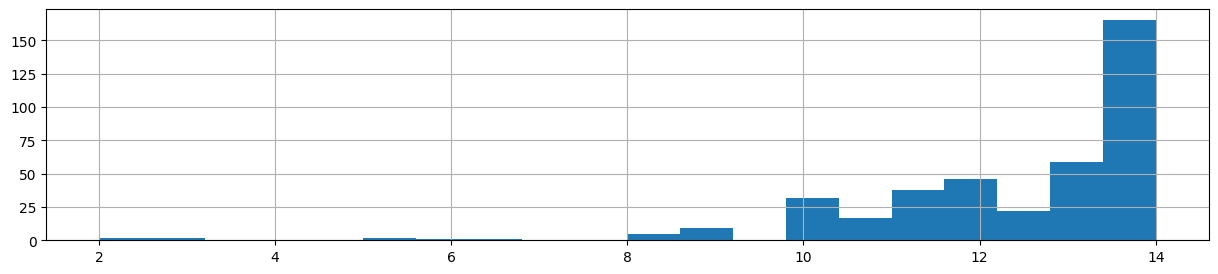

In [62]:
data['living_area'].hist(range=(2,14), figsize=(15,3), bins=20);



Можно удалить слишком маленькие квартиры, доля которых составляет 1%. Проведем границу по значению 14 кв. м.

In [63]:
data = data.drop(data[data['living_area'] < 14].index)

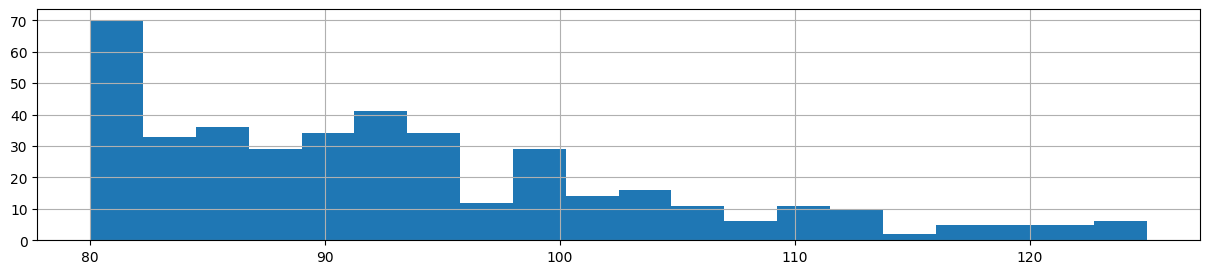

In [64]:
data['living_area'].hist(range=(80,125), figsize=(15,3), bins=20);

<div class='alert alert-info'>
    <font size="3", color = "black">

Удалим квартиры с жилой площадью 120 кв. м и более.

In [65]:
data = data.drop(data[data['living_area'] >= 120].index)
data['living_area'].describe()

count    21836.000000
mean        32.917697
std         15.931330
min         14.000000
25%         18.600000
50%         30.245000
75%         42.000000
max        119.900000
Name: living_area, dtype: float64

In [66]:
data['kitchen_area'].describe()

count    21836.000000
mean        10.133148
std          4.913852
min          1.300000
25%          7.100000
50%          9.100000
75%         11.200000
max         93.200000
Name: kitchen_area, dtype: float64

In [67]:
data['kitchen_area'].quantile([.01, .05, .1, .80, .95, .99])

0.01     5.0
0.05     5.5
0.10     6.0
0.80    12.0
0.95    18.0
0.99    30.0
Name: kitchen_area, dtype: float64



Очевидно аномальных значений в этом столбце не осталось.

In [68]:
data['floor'].describe()

count    21836.000000
mean         5.871909
std          4.834436
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

In [69]:
data['floor'].quantile([.01, .05, .1, .80, .9, .95, .99, .999])

0.010     1.0
0.050     1.0
0.100     1.0
0.800     9.0
0.900    13.0
0.950    16.0
0.990    23.0
0.999    26.0
Name: floor, dtype: float64

In [70]:
data['floors_total'].describe()

count    21836.000000
mean        10.681489
std          6.525509
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [71]:
data['floors_total'].quantile([.01, .05, .1, .80, .9, .95, .99, .999])

0.010     2.0
0.050     4.0
0.100     5.0
0.800    16.0
0.900    22.0
0.950    25.0
0.990    26.0
0.999    35.0
Name: floors_total, dtype: float64


Данные в столбцах в целом соотносятся между собой, есть значения, которые выбиваются из среднего, но далее мы будем анализировать категорию этажа, а не его абсолютное значение, значит, эти данные не исказят результатов исследования.



Посмотрим, что осталось от нашего датафрейма после предобработки.

In [72]:
# посчитаем, сколько значений мы удалили
diff = number_of_raw_data - len(data)
share_of_dropped_values = diff / number_of_raw_data
print(f'Доля удаленных значений составила {share_of_dropped_values:.1%}')

Доля удаленных значений составила 7.9%




Получилось, что мы удалили около 8% данных. Для такой неоднородной выборки этот показатель кажется допустимым. На следующем этапе, когда будет рассчитана стоимость квадратного метра, мы еще удалим квартиры, которые слишком сильно выделяются по этому параметру.

**На этапе предобработки данных мы сделали следующее:**
1. Изменили типы данных: `is_apartment` (столбец со значениями True и False) — на _bool_, `first_day_exposition` — на тип _datetime_ (чтобы можно было проводить дальнейшие преобразования с этими значениями и извлекать нужные данные, например месяц и год), `floors_total` — на целое число.

2. Обработали пропущенные значения:
- Заменили пропуски в столбцах `balcony`, `parks_around3000`, `ponds_around3000` на нули, поскольку логично предположить, что отсутствие значения в этом случае означает отсутствие балкона, парка и водоема соответственно;
- Обработали пропуски и аномальные значения в столбце `ceiling_height`: удалили строки с аномально большими и аномально маленькими значениями, разделили значение больше 20 м на 10, предположив, что при записи данных была допущена ошибка. После этого пропущенные данные заполнили медианным значением в зависимости от расположения квартиры (если квартира находится в центральной части Санкт-Петербурга, то потолки в ней, как правило, выше, чем у квартиры на окраине);
- Заменили пропущенные значения в столбце `floors_total` медианным значением по квартирам, расположенным на аналогичном этаже;
- Заменили пропущенные значения в столбце `living_area` медианными значениями по квартирам, имеющим аналогичное число комнат;
- Заменили пропущенные значения в столбце `kitchen_area` медианным значением по столбцу;
- Оставили пропущенные значения в столбцах `city_centers_nearest`, `days_exposition`, `parks_nearest`, `ponds_nearest`, `airports_nearest`;
- Удалили строки с пропущенными значениями в столбце `locality_name`;
- Обработали неявные дубликаты в столбце `locality_name`, записали обработанные данные в новый столбец `locality_processed`.

3. Обработали аномальные значения в данных:
- Сравнили значения в данных, которые связаны между собой (общая площадь и сумма жилой площади и кухни; общее количество этажей и номер этажа, на котором находится квартира), и установили наличие аномалий.
- Удалили значения, которые демонстрируют слишком значительное отклонение от среднего значения и медианы, поскольку таких значений незначительное количество, а учитывая, что мы имеем дело с неоднородной выборкой, такие данные могут искажать результаты исследования.

### Группировка данных

In [73]:
# удаляем служебные столбцы, которые мы использовали на этапе предобработки
del data['total_is_more']
del data['total_floors_ok'] 
del data['total_is_more_after']
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'locality_processed',
       'city_center_distance_spb'],
      dtype='object')

Рассчитаем цену квадратного метра в каждой квартире, добавим столбец.

In [74]:
# Чтобы узнать цену квадратного метра, разделим цену квартиры на ее площадь
data['price_per_sqm'] = data['last_price'] / data['total_area']


Посмотрим, есть ли аномальные данные в этом столбце.

In [75]:
data['price_per_sqm'].describe()

count    2.183600e+04
mean     9.806830e+04
std      4.517205e+04
min      1.118349e+02
25%      7.639089e+04
50%      9.466130e+04
75%      1.133333e+05
max      1.736842e+06
Name: price_per_sqm, dtype: float64

In [76]:
# посмотрим на квантили 
data['price_per_sqm'].quantile([.01,.05,.1,.9,.95,.99])

0.01     23400.966727
0.05     41504.415897
0.10     55813.953488
0.90    137500.000000
0.95    157733.492882
0.99    241956.166078
Name: price_per_sqm, dtype: float64

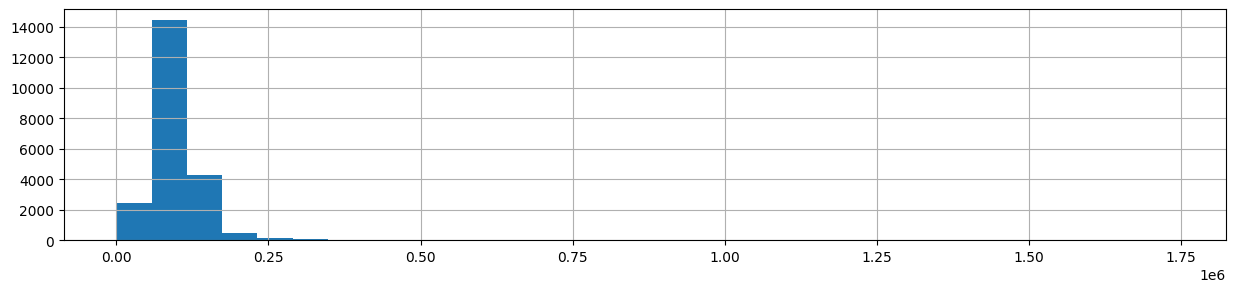

In [77]:
data['price_per_sqm'].hist(figsize=(15,3), bins=30);



На гистограмме видно, что граница аномальных для данной выборки значений проходит по числу 200_000, посчитаем аномалии.

In [78]:
len(data[data['price_per_sqm'] > 200_000])

392



Удалим слишком дорогие квартиры, чтобы они не искажали результаты исследования.

In [79]:
data = data.drop(data[data['price_per_sqm'] > 200_000].index)
data['price_per_sqm'].describe()

count     21444.000000
mean      94473.490660
std       31080.133179
min         111.834862
25%       75914.905568
50%       94038.734897
75%      112000.000000
max      200000.000000
Name: price_per_sqm, dtype: float64

Добавим столбец с днем недели, в который опубликовано объявление.

In [80]:
# делаем новый столбец, в нем 0 — понедельник, а 6 — воскресенье
data['weekday_of_exposition'] = data['first_day_exposition'].dt.weekday

Извлекаем информацию о месяце и годе публикации объявления в отдельные столбцы. 

In [81]:
data['month_of_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year_of_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_processed,city_center_distance_spb,price_per_sqm,weekday_of_exposition,month_of_exposition,year_of_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,482.0,2,755.0,NaN,Санкт-Петербург,Далеко от центра,120370.370370,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.60,11,18.6,1,True,...,NaN,0,NaN,81.0,Шушары,NaN,82920.792079,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.60,5,34.3,4,True,...,90.0,2,574.0,558.0,Санкт-Петербург,От 3 до 8 км от центра,92785.714286,3,8,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,112.0,1,48.0,121.0,Санкт-Петербург,До 3 км от центра,100000.000000,1,6,2018
5,10,2890000.0,30.4,2018-09-10,1,2.60,12,14.4,5,True,...,NaN,0,NaN,55.0,Янино-1,NaN,95065.789474,0,9,2018


Добавим столбец с категорией этажа (первый, последний, другой).

In [82]:
# объявляем функцию для категоризации этажей
def floor_category(row):
    floor = row['floor']
    number_of_floors = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == number_of_floors:
        return 'последний'
    elif floor == 0:
        return 'нулевой'
    elif floor < 0:
        return 'отрицательный'
    else:
        return 'другой'
    
data['floor_type'] = data.apply(floor_category, axis=1)

data['floor_type'].unique()
    

array(['другой', 'первый', 'последний'], dtype=object)



Отрицательных и нулевых этажей в датафрейме нет.

Переведем расстояние до центра города в километры и округлим до целых значений. Данные сохраним в столбце `city_centers_nearest_km`.

In [83]:
# делим метры на 1000, отбрасывая остаток
data['city_centers_nearest_km'] = (data['city_centers_nearest'] // 1000)

data['city_centers_nearest_km']


0        16.0
1        18.0
2        13.0
4         8.0
5         NaN
         ... 
23693    34.0
23694     4.0
23695     NaN
23696     NaN
23697    10.0
Name: city_centers_nearest_km, Length: 21444, dtype: float64

**В этой части проекта мы сделали следующее:**

- добавили столбец, где указана цена одного квадратного метра для каждой квартиры, и удалили квартиры со слишком большой стоимостью квадратного метра, чтобы распределение значений было более равномерным;
- добавили столбцы, где отдельно указаны день недели, месяц и год публикации объявления;
- добавили столбец с категорией этажа (первый, последний, другой);
- добавили столбец с расстоянием до центра города в километрах.

Далее мы будем использовать полученные данные в своем исследовании.

## Исследовательский анализ

### Обзор параметров

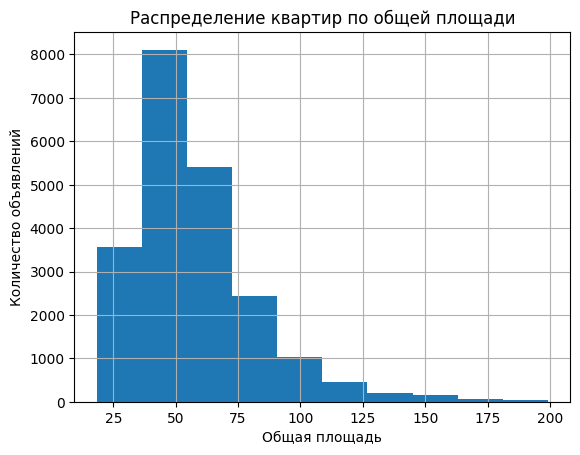

In [84]:
# строим гисторамму по столбцу total_area
plt.hist(data['total_area'])
plt.grid()
plt.title('Распределение квартир по общей площади')
plt.xlabel('Общая площадь')
plt.ylabel('Количество объявлений')
plt.show()

В таком виде гистограмма недостаточно информативна. Изменим параметры: увеличим количество корзин и уменьшим диапазон, чтобы более детально посмотреть частотные значения.

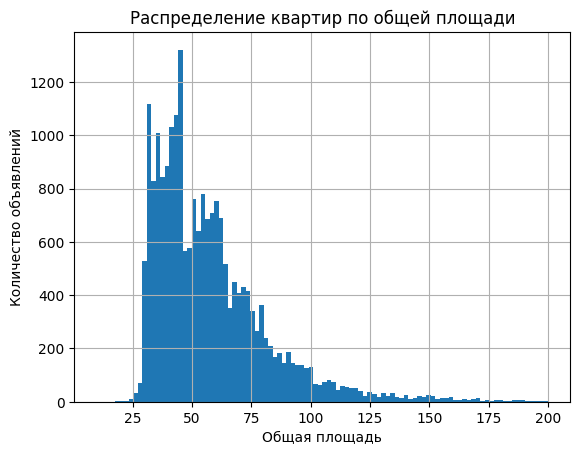

In [85]:
# меняем масштаб гистограммы
plt.hist(data['total_area'], bins=100, range=(10,200))
plt.grid()
plt.title('Распределение квартир по общей площади')
plt.xlabel('Общая площадь')
plt.ylabel('Количество объявлений')
plt.show()



Наибольшее количество квартир имеют общую площадь в диапазоне от 30 до 100 кв. м. Пиковое значение — в районе 40 кв. м. Построим гистограммы по остальным параметрам.

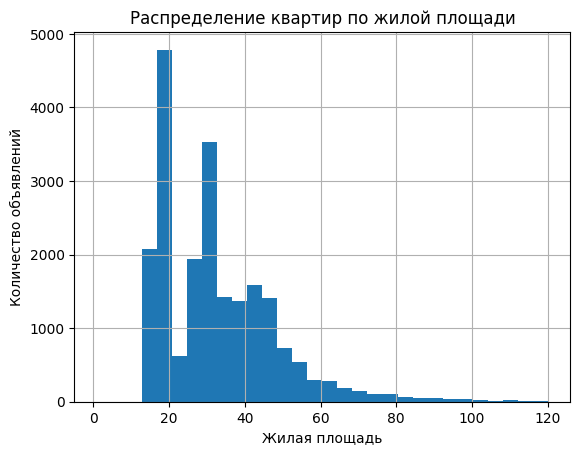

In [86]:
# строим гистограмму по жилой площади квартир
plt.hist(data['living_area'], bins=30, range = (1, 120))
plt.grid()
plt.title('Распределение квартир по жилой площади')
plt.xlabel('Жилая площадь')
plt.ylabel('Количество объявлений')
plt.show()


Больше всего квартир имеют жилую площадь 18—20 кв. м., второй пик — в районе 30—35 кв. м. Наиболее частотные значения — в диапазоне 15—55 кв. м.

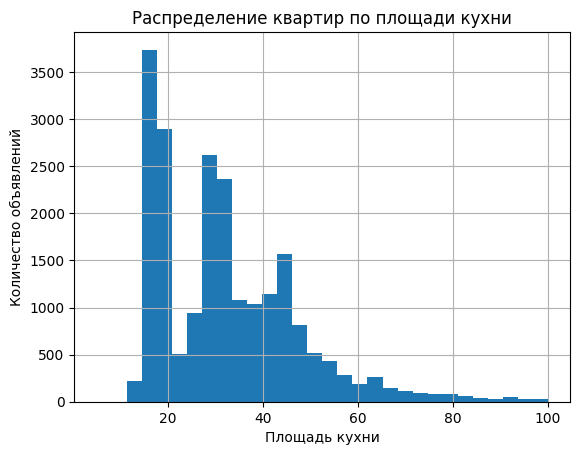

In [87]:
# строим гистограмму по площади кухни
plt.hist(data['living_area'], bins=30, range = (5, 100))
plt.grid()
plt.title('Распределение квартир по площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Количество объявлений')
plt.show()


Большинство квартир имеют площадь кухни в диапазоне 15—50 кв. м. Больше всего квартир — с кухней около 18 кв. м.

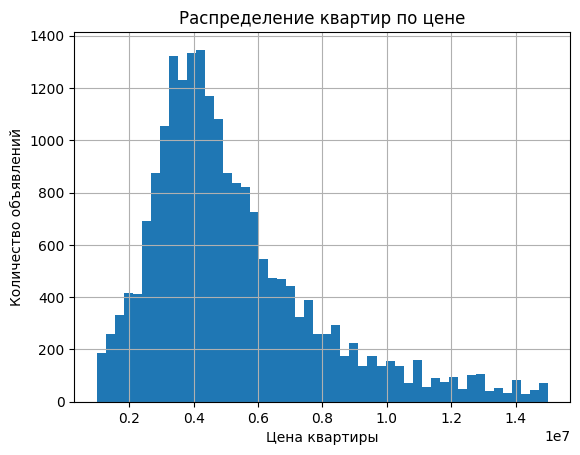

In [88]:
# строим гистограмму по цене квартир
plt.hist(data['last_price'],bins=50,range=(1_000_000,15_000_000))
plt.grid()
plt.title('Распределение квартир по цене')
plt.xlabel('Цена квартиры')
plt.ylabel('Количество объявлений')
plt.show()


Больше всего квартир — в диапазоне от 2 млн до 8 млн рублей. 

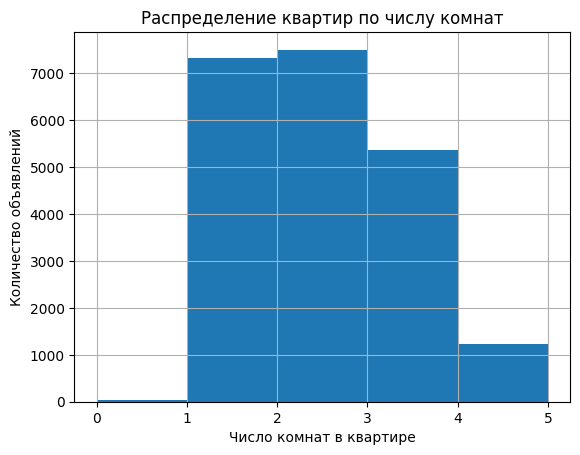

In [89]:
# строим гистограмму по числу комнат
plt.hist(data['rooms'],range=(0,5), bins=5)
plt.grid()
plt.title('Распределение квартир по числу комнат')
plt.xlabel('Число комнат в квартире')
plt.ylabel('Количество объявлений')
plt.show()


Больше всего — двухкомнатных квартир (около 7,5 тыс.), чуть меньше — однокомнатных (около 7.3 тыс.). Трехкомнатных — около 5.3 тыс. Четырехкомнатных — 1 тыс. Пятикомнатных и квартир с 0 комнат — незначительное количество по сравнению с числом квартир в выборке.

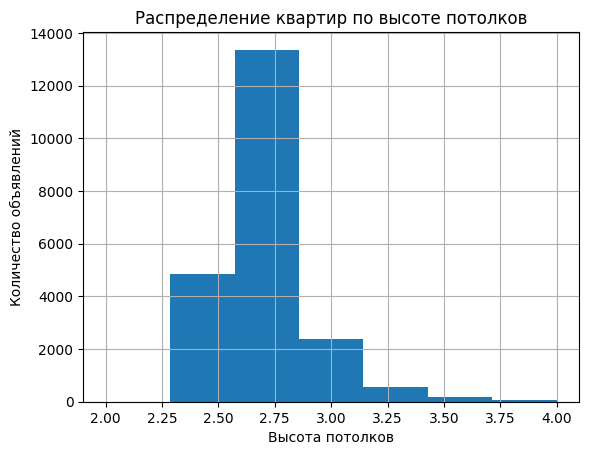

In [90]:
# строим гистограмму по высоте потолков
plt.hist(data['ceiling_height'],range=(2,4),bins=7)
plt.grid()
plt.title('Распределение квартир по высоте потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Количество объявлений')
plt.show()


Данные в этом столбце соответствуют представлениям о высоте потолков в квартире: больше всего квартир с потолками в районе 2.7 м.

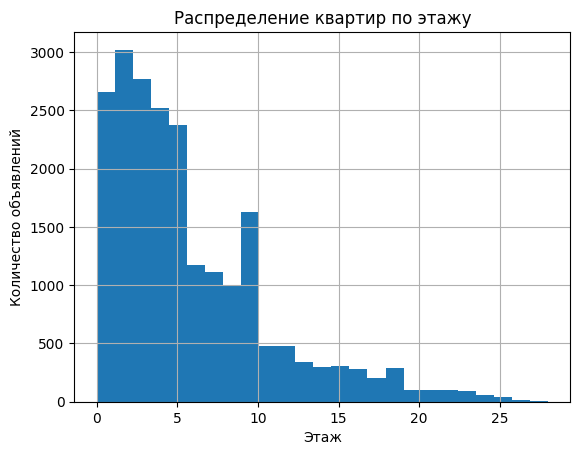

In [91]:
# строим гистограмму по этажу, на котором расположена квартира
plt.hist(data['floor'],bins=25, range=(0, 28))
plt.grid()
plt.title('Распределение квартир по этажу')
plt.xlabel('Этаж')
plt.ylabel('Количество объявлений')
plt.show()


Больше всего квартир располагаются на этажах от первого до пятого, группа поменьше — от пятого до девятого. Далее идет постепенный спад. Это, скорее всего, связано с тем, что значительная часть домов в России — это пяти- и девятиэтажки.

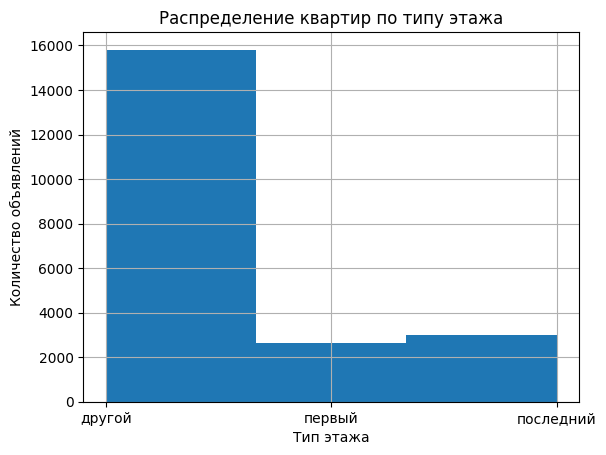

In [92]:
# строим гистограмму по типу этажа (первый, последний, другой)
plt.hist(data['floor_type'], bins=3)
plt.grid()
plt.title('Распределение квартир по типу этажа')
plt.xlabel('Тип этажа')
plt.ylabel('Количество объявлений')
plt.show()


Больше всего квартир — в категории «другой» (то есть не первый и не последний этаж). Это связано с тем, что категория «другой» включает в себя все этажи, кроме перого и последнего, то есть она по определению более многочисленна.

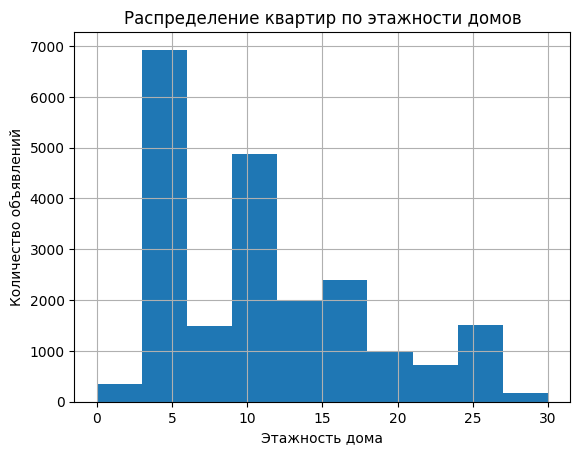

In [93]:
# строим гистограмму по этажности домов
plt.hist(data['floors_total'], range=(0,30))
plt.grid()
plt.title('Распределение квартир по этажности домов')
plt.xlabel('Этажность дома')
plt.ylabel('Количество объявлений')
plt.show()


Пиковые значения этажности приходятся на пяти- и девятиэтажки, что логично, поскольку это самый распространенный тип жилых многоквартирных домов в нашей стране. Далее по численности идут квартиры в 16-этажках и 25-этажках, более высотные здания встречаются реже (так же редко, как и дома менее 4 этажей).

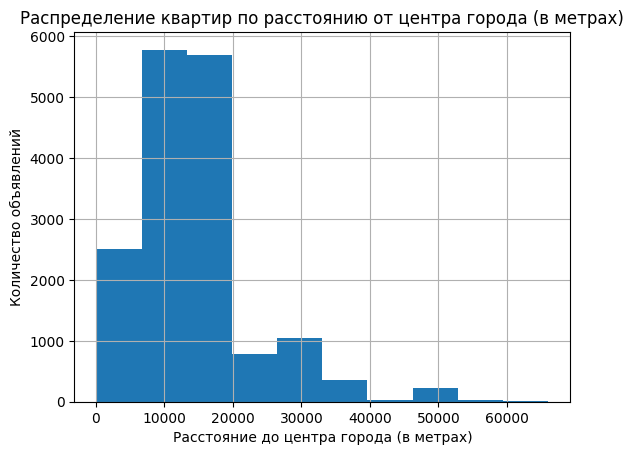

In [94]:
# строим гистограмму по расстоянию до центра города
plt.hist(data['city_centers_nearest'])
plt.grid()
plt.title('Распределение квартир по расстоянию от центра города (в метрах)')
plt.xlabel('Расстояние до центра города (в метрах)')
plt.ylabel('Количество объявлений')
plt.show()


Больше всего квартир в данных находятся в диапазоне от 8 до 20 км от центра города. Квартиры с расстоянием до 8 км от центра составляют примерно половину от пикового значения. После 20 км идет спад. Возможно, это связано с тем, что если квартира сильно удалена от центра, то эта географическая привязка не играет большой роли, а значимыми становятся другие факторы, например наличие школ, близость крупных торговых центров, удобный съезд на магистраль и пр.

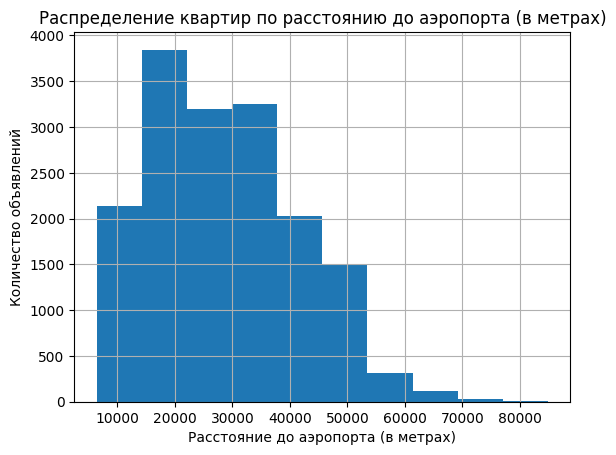

In [95]:
# строим гистограмму по расстоянию до аэропорта
plt.hist(data['airports_nearest'])
plt.grid()
plt.title('Распределение квартир по расстоянию до аэропорта (в метрах)')
plt.xlabel('Расстояние до аэропорта (в метрах)')
plt.ylabel('Количество объявлений')
plt.show()


Большая часть квартир находятся в диапазоне от 10 до 42 км от аэропорта. Распределение выглядит нормальным. 

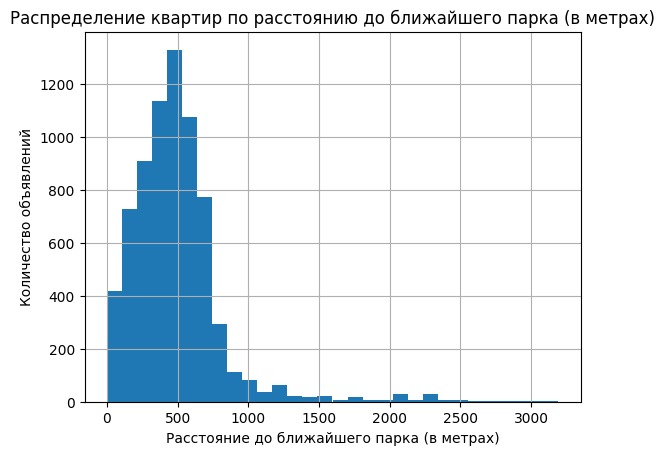

In [96]:
# строим гистограмму по расстоянию до ближайшего парка
plt.hist(data['parks_nearest'], bins=30)
plt.grid()
plt.title('Распределение квартир по расстоянию до ближайшего парка (в метрах)')
plt.xlabel('Расстояние до ближайшего парка (в метрах)')
plt.ylabel('Количество объявлений')
plt.show()


У большинства квартир в таблице указано, что расстояние до ближайшего парка составляет 500 метров, частотные значения располагаются в диапазоне от 0 до 750 метров. Есть несколько нулевых значений, но их количество незначительно (что видно при уменьшении диапазона по оси x — см. гистограмму ниже).

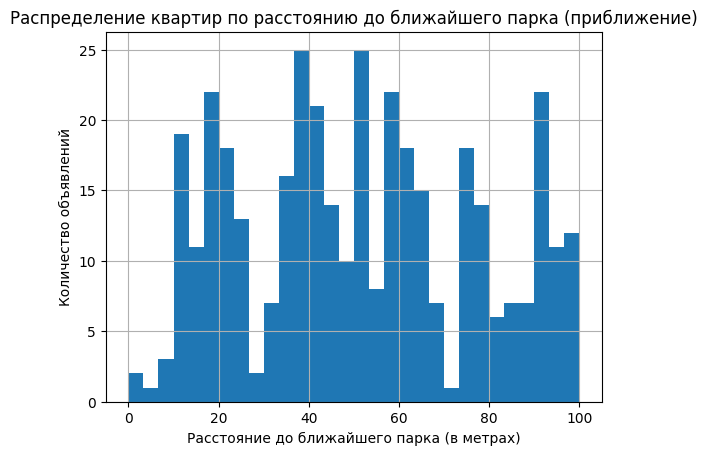

In [97]:
# строим гистограмму, чтобы «приблизить» участок в районе 0
plt.hist(data['parks_nearest'], bins=30, range=(0,100))
plt.grid()
plt.title('Распределение квартир по расстоянию до ближайшего парка (приближение)')
plt.xlabel('Расстояние до ближайшего парка (в метрах)')
plt.ylabel('Количество объявлений')
plt.show()


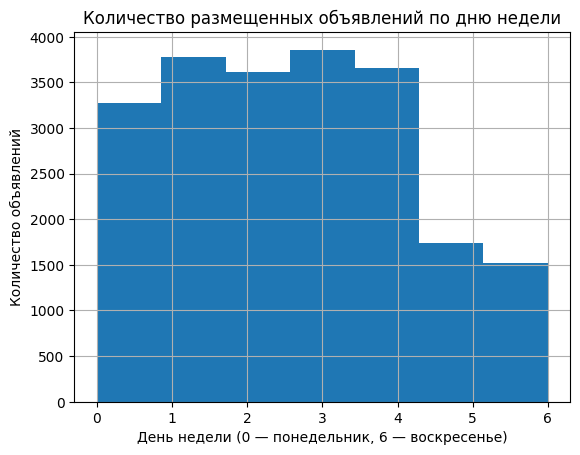

In [98]:
# строим гистограмму по дню недели публикации объявления
plt.hist(data['weekday_of_exposition'], bins=7)
plt.grid()
plt.title('Количество размещенных объявлений по дню недели')
plt.xlabel('День недели (0 — понедельник, 6 — воскресенье)')
plt.ylabel('Количество объявлений')
plt.show()


На этой гистограмме отчетливо видно, что наибольшее количество объявлений публикуется со вторника по пятницу, в выходные наступает спад. Это связано с естественной рабочей активностью людей.

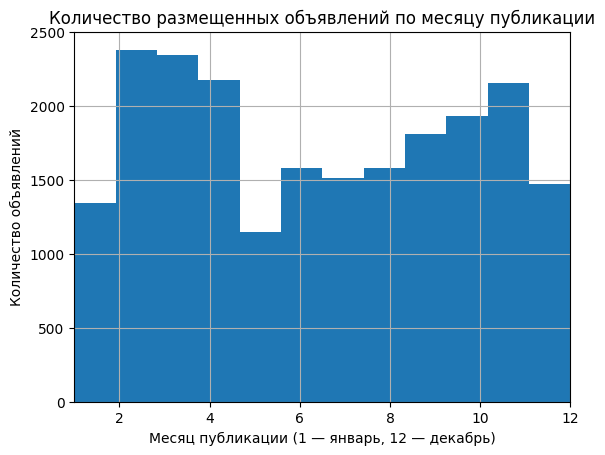

In [99]:
# строим гистограмму по месяцу публикации объявления
plt.hist(data['month_of_exposition'], bins=12, range=(1,12))
plt.xlim([1,12])
plt.grid()
plt.title('Количество размещенных объявлений по месяцу публикации')
plt.xlabel('Месяц публикации (1 — январь, 12 — декабрь)')
plt.ylabel('Количество объявлений')
plt.show()


На гистограмме явно прослеживается сезонность: больше всего объявлений — с февраля по апрель, начиная с мая и летом — в сезон отпусков — объявлений становится значительно меньше, рост начинается с началом осени и продолжается до конца весны с перерывом в декабре-январе в связи с новогодними праздниками и периодом зимних отпусков.

### Скорость продажи квартир

Изучим данные о периоде времени продажи квартир. Эта информация содержится в столбце `days_exposition`.

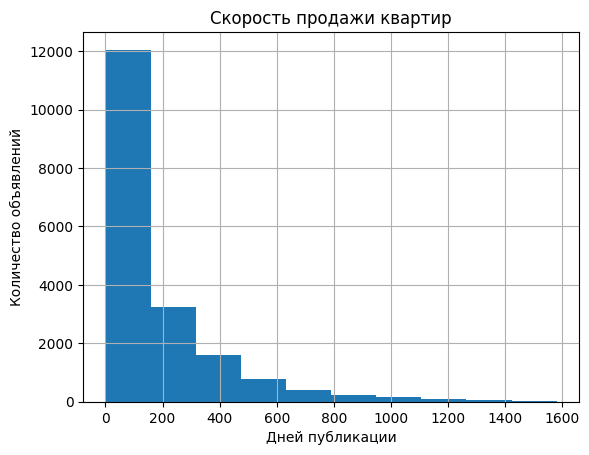

In [100]:
# строим гистограмму по столбцу 
plt.hist(data['days_exposition'])
plt.grid()
plt.title('Скорость продажи квартир')
plt.xlabel('Дней публикации')
plt.ylabel('Количество объявлений')
plt.show()


Пиковые значения приходятся на диапазон от 0 до 180 дней. Есть также значения более 400 дней, которые выглядят необычно долгими (продажа квартиры более года). Проведем границу по значению 400 и построим гистограмму в этом диапазоне, чтобы более детально увидеть данные по частотным значениям.

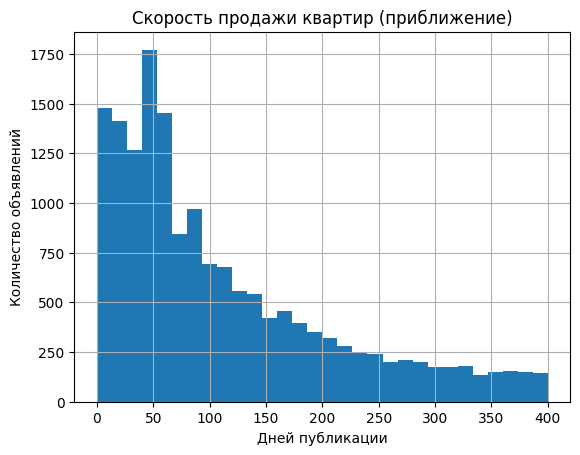

In [101]:
# изменяем масштаб гистограммы
plt.hist(data['days_exposition'], range=(0, 400), bins=30)
plt.grid()
plt.title('Скорость продажи квартир (приближение)')
plt.xlabel('Дней публикации')
plt.ylabel('Количество объявлений')
plt.show()


Пиковое значение времени продажи — в районе 1—90 дней. Имеется довольно большое число значений, близких к нулю. Посмотрим детальнее.

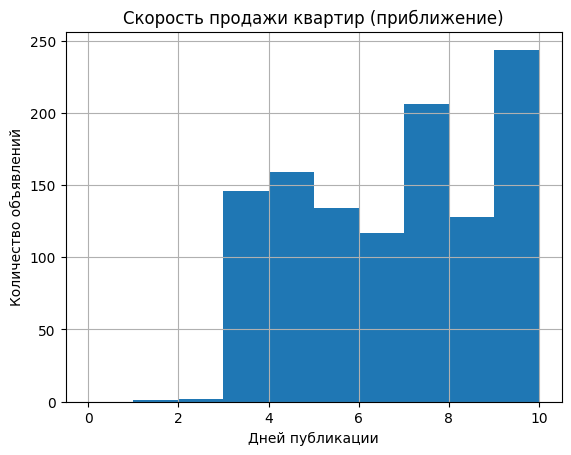

In [102]:
# задаем диапазон дней от 0 до 10
# изменяем масштаб гистограммы
plt.hist(data['days_exposition'], range=(0, 10))
plt.grid()
plt.title('Скорость продажи квартир (приближение)')
plt.xlabel('Дней публикации')
plt.ylabel('Количество объявлений')
plt.show()



Есть небольшое количество объявлений, где период продажи составляет менее 2 дней. Посмотрим, сколько их.

In [103]:
# смотрим, сколько строк, где указано, что время продажи квартиры — менее двух дней
data[data['days_exposition'] < 2]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,locality_processed,city_center_distance_spb,price_per_sqm,weekday_of_exposition,month_of_exposition,year_of_exposition,floor_type,city_centers_nearest_km
1632,19,4000000.0,49.9,2019-05-01,2,2.5,9,25.0,1,True,...,681.0,1.0,Санкт-Петербург,От 3 до 8 км от центра,80160.320641,2,5,2019,первый,14.0


In [104]:
# такая строка всего одна, удалим ее
data = data.drop(data[data['days_exposition'] < 2].index)

In [105]:
# считаем медиану по столбцу
data['days_exposition'].median()

96.0

In [106]:
# считаем среднее по столбцу
data['days_exposition'].mean()

180.21637301246238

Мы видим, что между средним значением и медианой — значительная разница. Посмотрим, в скольких строках указано необычно долгое время продажи. В качестве рубежа возьмем 400 дней.

In [107]:
len(data[data['days_exposition'] > 400])

2371

Строк с необычно большим значением в данных о периоде времени — значительное количество. Посмотрим, есть ли зависимость между временем продажи и другими параметрами в случае слишком длительного периода продажи.

In [108]:
# делаем таблицу с данными, отфильтрованными по периоду продажи (более 400 дней)
long_sale = data[data['days_exposition'] > 400]
# смотрим, есть ли зависимость в этих данных между временем продажи и другими параметрами
long_sale.corr()

<ipython-input-108-839a2a3202cf>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  long_sale.corr()


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sqm,weekday_of_exposition,month_of_exposition,year_of_exposition,city_centers_nearest_km
total_images,1.000000,0.073461,0.079995,0.079354,-0.004494,-0.036333,0.074107,0.013523,0.056142,-0.013046,...,-0.022138,0.020485,-0.045030,0.034383,-0.075852,0.042406,0.021475,-0.006971,0.174394,0.010258
last_price,0.073461,1.000000,0.824565,0.539359,0.541662,0.071848,0.694817,0.090286,-0.034144,0.027949,...,0.288918,0.027483,0.341755,-0.062651,0.102868,0.659188,-0.026742,0.065693,-0.047857,-0.371820
total_area,0.079995,0.824565,1.000000,0.803501,0.482966,-0.044268,0.925082,-0.009700,-0.033678,0.002286,...,0.203808,-0.026437,0.229908,-0.027236,0.101872,0.189027,-0.025344,0.050593,-0.065612,-0.250161
rooms,0.079354,0.539359,0.803501,1.000000,0.306922,-0.207836,0.897152,-0.136818,-0.024135,-0.063158,...,0.157568,-0.107003,0.145419,0.000818,0.072393,-0.060377,-0.029353,0.038024,-0.055134,-0.178125
ceiling_height,-0.004494,0.541662,0.482966,0.306922,1.000000,-0.142737,0.443819,-0.077564,-0.043749,0.021775,...,0.295353,-0.068643,0.286567,-0.070037,0.081832,0.387492,-0.024727,-0.011654,-0.020772,-0.446949
floors_total,-0.036333,0.071848,-0.044268,-0.207836,-0.142737,1.000000,-0.164173,0.658403,-0.027054,0.018876,...,-0.137107,0.080164,-0.046703,-0.059654,0.006642,0.256627,0.024460,-0.006120,-0.015605,0.034580
living_area,0.074107,0.694817,0.925082,0.897152,0.443819,-0.164173,1.000000,-0.098190,-0.037144,0.005825,...,0.206055,-0.080869,0.191539,-0.002670,0.073302,0.058921,-0.031080,0.033003,-0.056701,-0.237530
floor,0.013523,0.090286,-0.009700,-0.136818,-0.077564,0.658403,-0.098190,1.000000,-0.053279,-0.022070,...,-0.081369,0.050549,-0.016648,-0.044959,-0.001694,0.211267,0.015309,0.001998,-0.010776,0.015209
is_apartment,0.056142,-0.034144,-0.033678,-0.024135,-0.043749,-0.027054,-0.037144,-0.053279,1.000000,0.013148,...,-0.004160,-0.007964,-0.027437,0.069687,0.024095,-0.020735,0.021891,0.077185,0.169436,0.015650
studio,-0.013046,0.027949,0.002286,-0.063158,0.021775,0.018876,0.005825,-0.022070,0.013148,1.000000,...,-0.000246,0.008613,-0.005444,0.021167,-0.014088,0.044243,-0.017084,0.033239,0.018518,-0.023548


В данных с длительным периодом продажи не обнаружено четкой зависимости между периодом продажи и другими параметрами, указанными в объявлении. Поскольку таких данных значительное количество и их нельзя просто удалить, мы будем иметь в виду этот разброс и ориентироваться на медианное значение периода продажи, а не среднее. Как мы рассчитали ранее, медиана по столбцу `days_exposition` составляет 96 дней (около трех месяцев).


Посмотрим, какие значения встречаются в этом столбце чаще всего.

In [109]:
data['days_exposition'].value_counts().sort_values(ascending=False)

45.0      768
60.0      502
7.0       206
30.0      192
4.0       159
         ... 
994.0       1
982.0       1
988.0       1
1080.0      1
808.0       1
Name: days_exposition, Length: 1115, dtype: int64

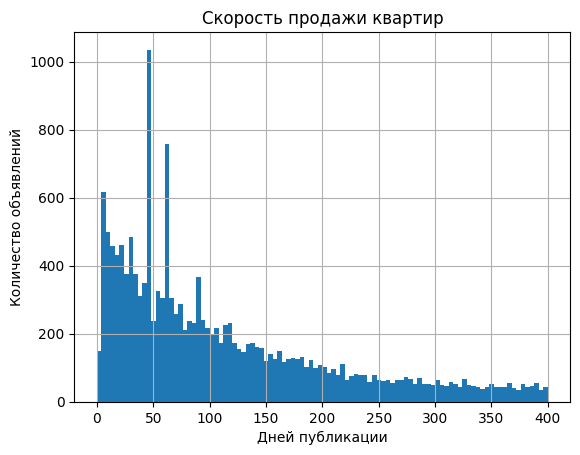

In [110]:
plt.hist(data['days_exposition'], range=(0, 400), bins=100)
plt.grid()
plt.title('Скорость продажи квартир')
plt.xlabel('Дней публикации')
plt.ylabel('Количество объявлений')
plt.show()


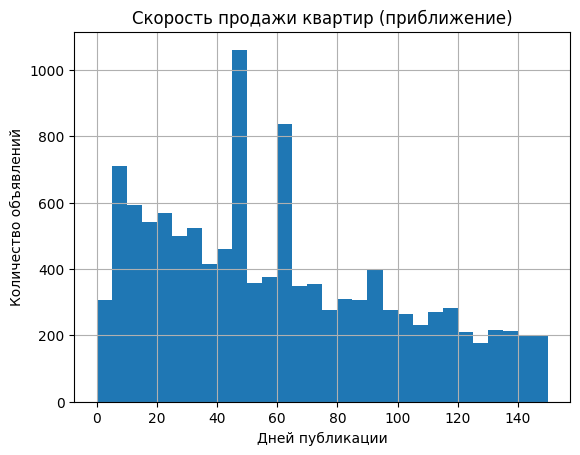

In [111]:
# изменяем масштаб гистограммы
plt.hist(data['days_exposition'], range=(0, 150), bins=30)
plt.grid()
plt.title('Скорость продажи квартир (приближение)')
plt.xlabel('Дней публикации')
plt.ylabel('Количество объявлений')
plt.show()



На гистограммах отчетливо выделяются периоды в 45, 60 и 90 дней. Это связано с условиями публикации объявлений на сервисе «Яндекс.Недвижимость». 

Рассчитаем среднюю скорость продажи по годам.

In [112]:
days_exposition_grouped_by_year = (data.groupby('year_of_exposition')
                                   ['days_exposition'].mean()
                                   .sort_values(ascending=False)
                                   .reset_index())
days_exposition_grouped_by_year

,year_of_exposition,days_exposition
0,2014,913.509615
1,2015,648.916834
2,2016,323.485222
3,2017,158.672483
4,2018,94.299869
5,2019,30.870935


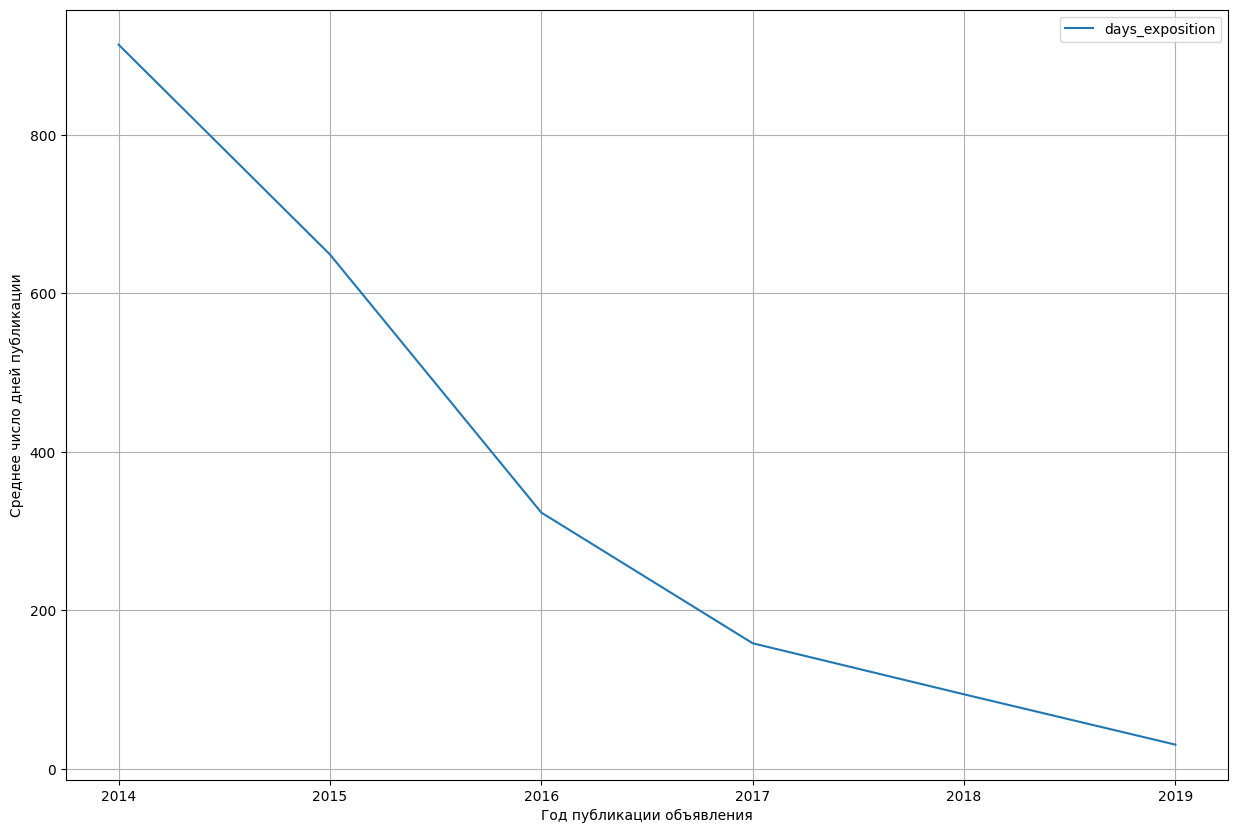

In [114]:
days_exposition_grouped_by_year.plot(x='year_of_exposition',
                                     y='days_exposition', 
                                     grid=True,                                    
                                     figsize=(15,10),
                                     xlabel='Год публикации объявления',
                                     ylabel='Среднее число дней публикации');


Количество дней публикации объявления снижается с каждым годом. Скорее всего, это связано с ростом популярности сервиса.

### Влияние различных факторов на стоимость квартиры

Выясним, какие параметры в наибольшей степени влияют на стоимость квартиры. Сначала установим, есть ли прямая зависимость между стоимостью объекта и общей площадью.

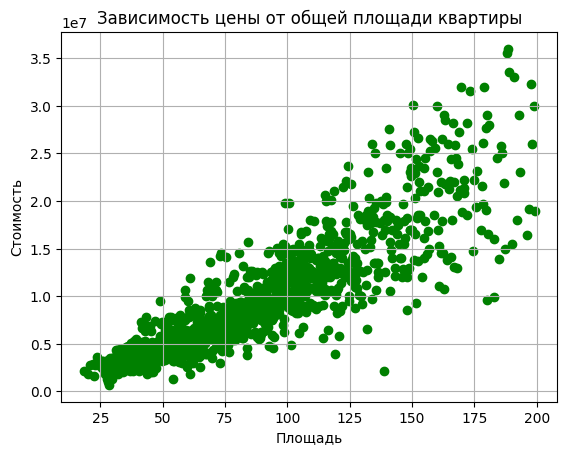

In [116]:
# Строим сводную таблицу по total_area и медианному значению last_price
total_area_pivot = data.pivot_table(index='total_area', 
                                    values='last_price', aggfunc='median')

# Сбрасываем индексы, чтобы удобнее было работать с таблицей
total_area_pivot.reset_index(inplace=True)

# Строим диаграмму рассеяния
plt.scatter(total_area_pivot['total_area'], total_area_pivot['last_price'], c='green')
plt.title('Зависимость цены от общей площади квартиры')
plt.grid()
plt.ylabel('Стоимость')
plt.xlabel('Площадь');


На этой диаграмме видно, что, за исключением некоторых единичных данных, между общей площадью квартиры и ее стоимостью есть прямая зависимость. Построим более детальную диаграмму для области с наибольшей концентрацией значений.

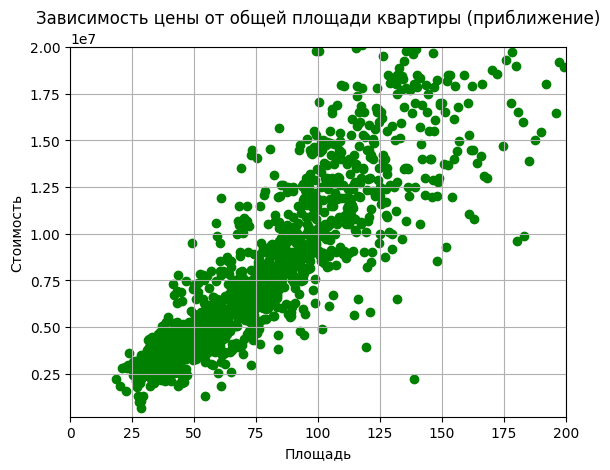

In [117]:
# Задаем диапазоны для осей x и y (общая площадь — менее 200 кв. м, 
# цена от 200 тыс. до 20 млн рублей)
plt.scatter(total_area_pivot['total_area'], total_area_pivot['last_price'], c='green')
plt.xlim(0,200)
plt.ylim(200_000, 20_000_000)
plt.grid()
plt.title('Зависимость цены от общей площади квартиры (приближение)')
plt.ylabel('Стоимость')
plt.xlabel('Площадь');



На этом графике зависимость прослеживается более четко: наглядно видно, что между стоимостью квартиры и ее площадью есть прямая зависимость.

In [ ]:
# Посмотрим на коэффициент корреляции
total_area_pivot.corr()

,total_area,last_price
total_area,1.000000,0.897554
last_price,0.897554,1.000000


Коэффициент корреляции между общей площадью квартиры и ее ценой также свидетельствует о наличии прямой зависимости между этими параметрами. Посмотрим, как на цену квартиры влияет ее жилая площадь.

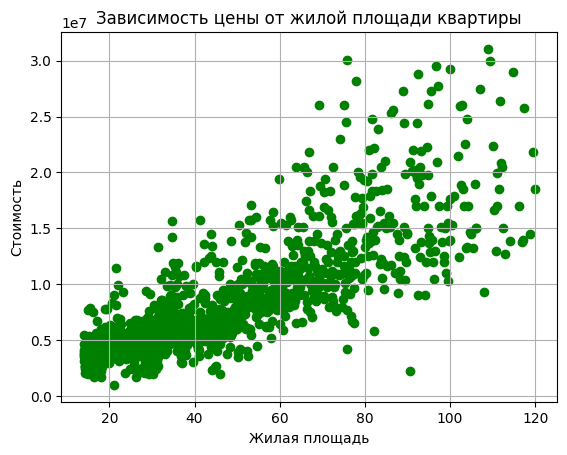

In [118]:
# Строим сводную таблицу по living_area и медианному значению last_price
living_area_pivot = data.pivot_table(index='living_area', 
                                     values='last_price', aggfunc='median')

# Сбрасываем индексы, чтобы удобнее было работать с таблицей
living_area_pivot.reset_index(inplace=True)

# Строим диаграмму рассеяния
plt.scatter(living_area_pivot['living_area'], living_area_pivot['last_price'], c='green')
plt.grid()
plt.title('Зависимость цены от жилой площади квартиры')
plt.ylabel('Стоимость')
plt.xlabel('Жилая площадь');




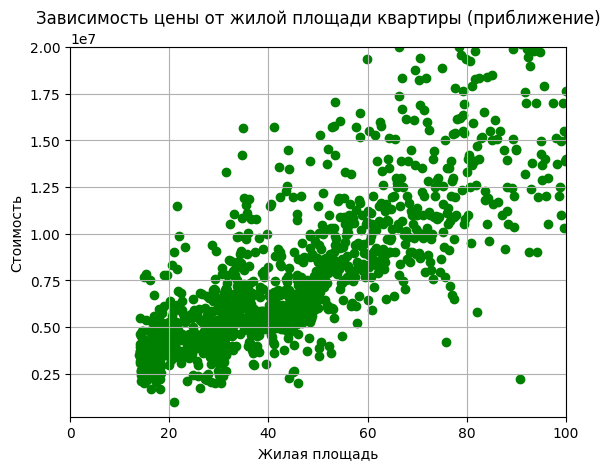

In [119]:
# Задаем диапазоны для осей x и y (жилая площадь — менее 100 кв. м, 
# цена от 200 тыс. до 20 млн рублей)
plt.scatter(living_area_pivot['living_area'], living_area_pivot['last_price'], c='green')
plt.xlim(0,100)
plt.ylim(200_000, 20_000_000)
plt.grid()
plt.title('Зависимость цены от жилой площади квартиры (приближение)')
plt.ylabel('Стоимость')
plt.xlabel('Жилая площадь');


Мы видим, что в случае жилой площади также имеется прямая корреляция с ценой.

In [ ]:
# Посмотрим на коэффициент корреляции
living_area_pivot.corr()

,living_area,last_price
living_area,1.00000,0.82424
last_price,0.82424,1.00000


Посмотрим на связь между площадью кухни и ценой.

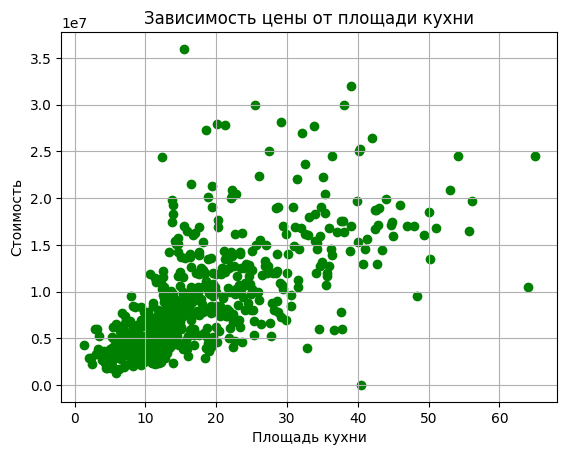

In [120]:
# Строим сводную таблицу по kitchen_area и медианному значению last_price
kitchen_area_pivot = data.pivot_table(index='kitchen_area', 
                                      values='last_price', aggfunc='median')

# Сбрасываем индексы, чтобы удобнее было работать с таблицей
kitchen_area_pivot.reset_index(inplace=True)

# Строим диаграмму рассеяния
plt.scatter(kitchen_area_pivot['kitchen_area'], kitchen_area_pivot['last_price'], c='green')
plt.grid()
plt.title('Зависимость цены от площади кухни')
plt.ylabel('Стоимость')
plt.xlabel('Площадь кухни');




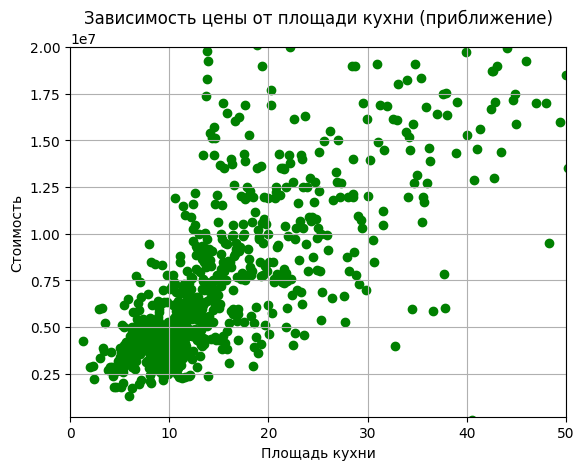

In [121]:
# Задаем диапазоны для осей x и y (площадь кухни — менее 50 кв. м, 
# цена от 200 тыс. до 20 млн рублей)
plt.scatter(kitchen_area_pivot['kitchen_area'], kitchen_area_pivot['last_price'], c='green')
plt.xlim(0,50)
plt.ylim(200_000, 20_000_000)
plt.grid()
plt.title('Зависимость цены от площади кухни (приближение)')
plt.ylabel('Стоимость')
plt.xlabel('Площадь кухни');



Хотя значения неравномерно распределены, общая тенденция указывает на то, что корреляция между площадью кухни и стоимостью есть, но она немного меньше, чем между другими показателями площади (общей площадью и жилой площадью). 

In [ ]:
kitchen_area_pivot.corr()

,kitchen_area,last_price
kitchen_area,1.000000,0.716104
last_price,0.716104,1.000000



Построим промежуточную диаграмму, чтобы посмотреть, площадь каких помещений в квартире в наибольшей степени влияет на ее стоимость.

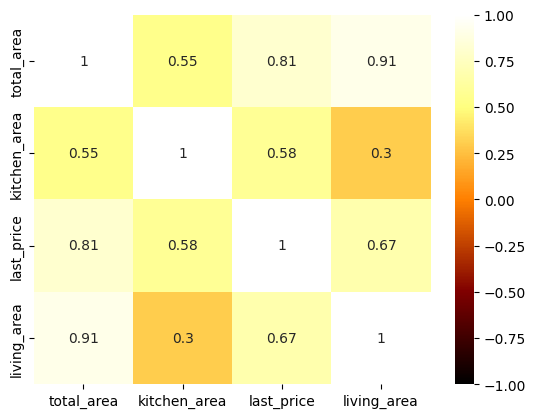

In [122]:
sns.heatmap(
    data[['total_area', 'kitchen_area', 'last_price', 'living_area']].corr(),        
    cmap='afmhot', 
    annot=True, 
    vmin=-1, vmax=1);


Таким образом, стоимость квартиры пропорционально увеличивается по мере роста ее общей площади. Также большую роль играет жилая площадь. Между ценой и площадью кухни корреляция значительно меньше. Речь идет об усредненных показателях (то есть увеличение площади квартиры при прочих равных условиях, вне зависимости от других факторов).

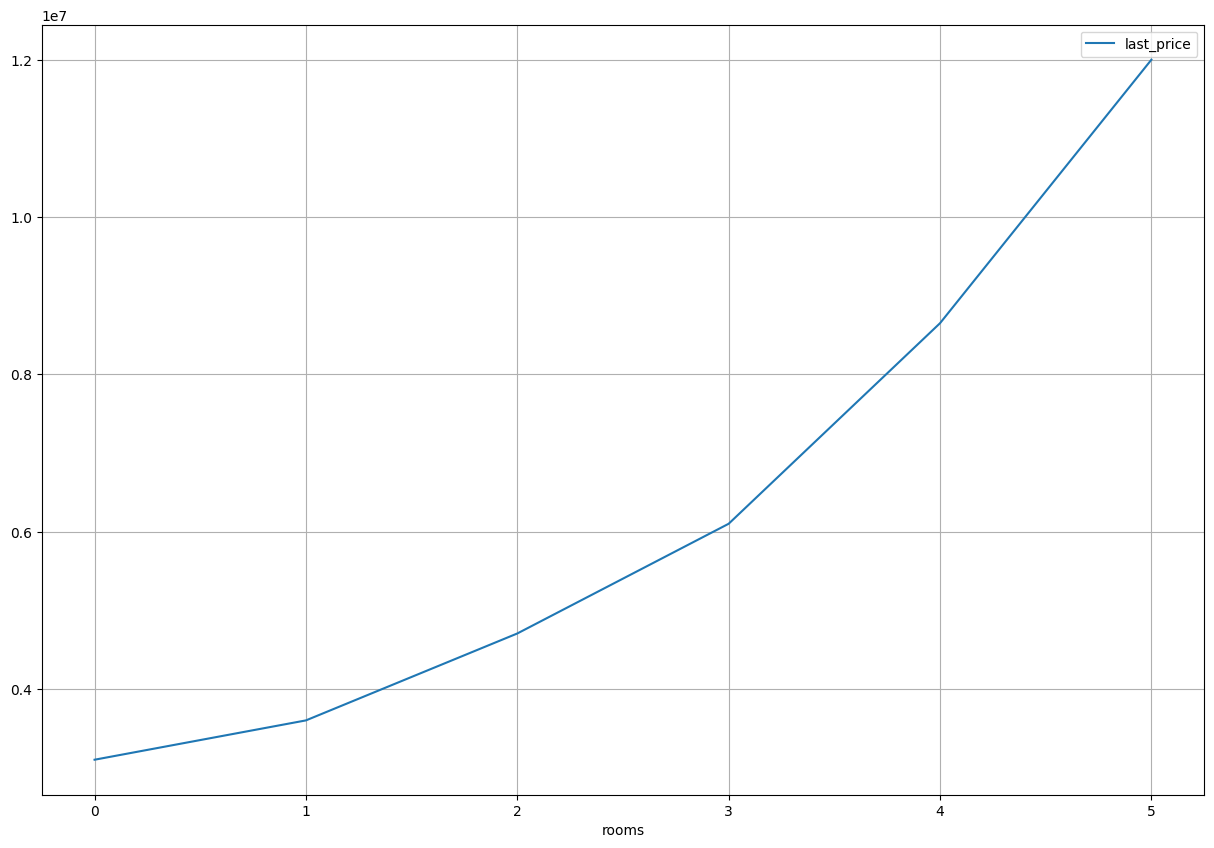

In [123]:
# Строим сводную таблицу по количеству комнат и медианному значению last_price
rooms_pivot = data.pivot_table(index='rooms', values='last_price', aggfunc='median')

# Сбрасываем индексы, чтобы удобнее было работать с таблицей
rooms_pivot.reset_index(inplace=True)

# Строим график
rooms_pivot.plot(kind='line', x='rooms', y='last_price', grid=True, figsize=(15,10));



В квартирах до пяти комнат рост цены прямо пропорционален росту числа комнат в квартире.

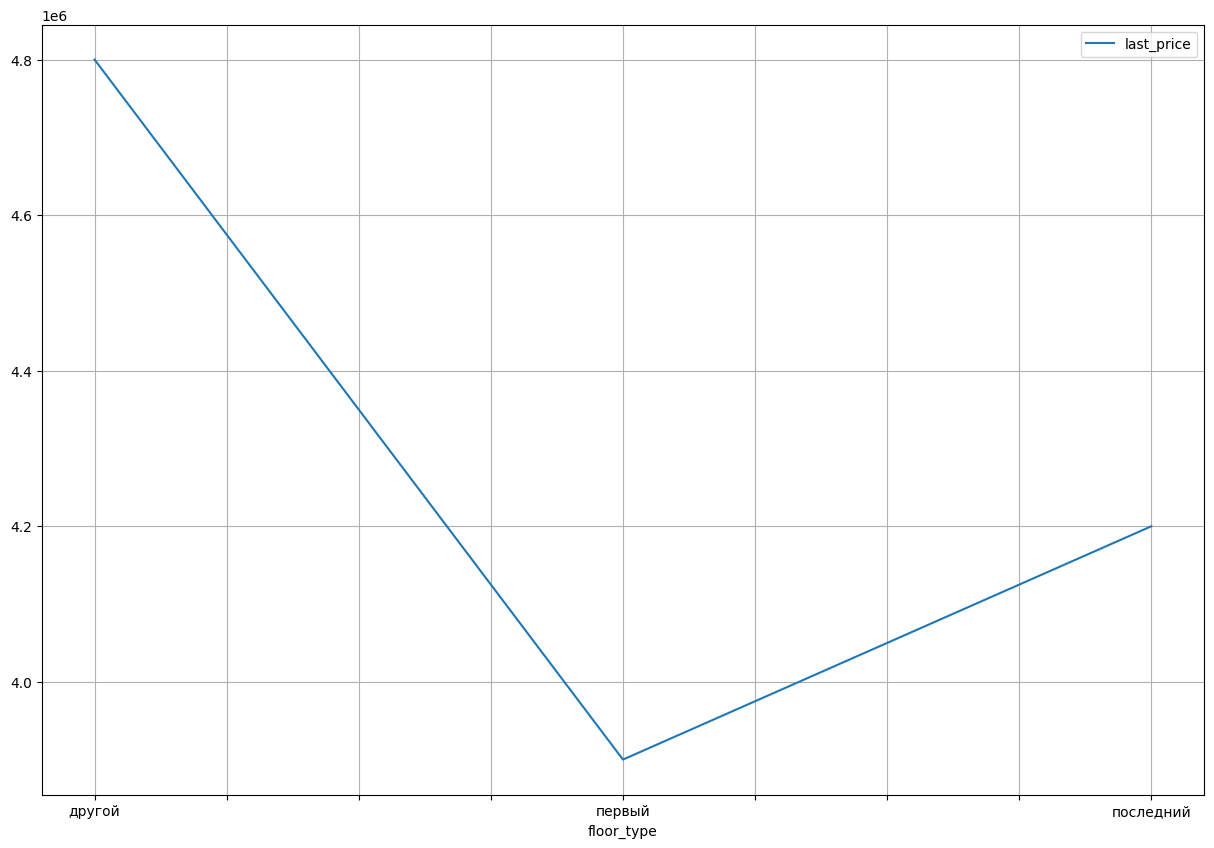

In [125]:
# Строим сводную таблицу по типу этажа и медианному значению last_price
floor_type_pivot = data.pivot_table(index='floor_type', values='last_price', aggfunc='median')

# Сбрасываем индексы, чтобы удобнее было работать с таблицей
floor_type_pivot.reset_index(inplace=True)

# Строим график
floor_type_pivot.plot(kind='line', 
                      x='floor_type', y='last_price', 
                      grid=True, figsize=(15,10));


На графике видно, что самые дешевые квартиры располагаются на первом этаже, а самые дорогие — на других этажах. В категории «последний» — средний показатель по цене. Как мы помним из нашего исследования, в категории «другой» квартир больше всего.

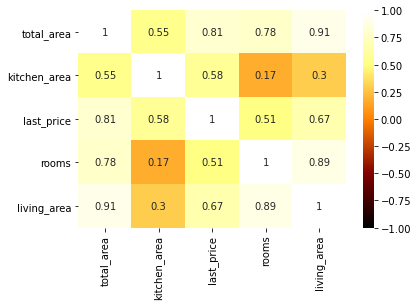

In [ ]:
# Строим промежуточную диаграмму по исследованным параметрам
sns.heatmap(
    data[['total_area', 'kitchen_area', 'last_price',
          'rooms', 'living_area']].corr(),        
    cmap='afmhot', 
    annot=True, 
    vmin=-1, vmax=1);


Наибольшая корреляция у цены — с общей площадью квартиры.

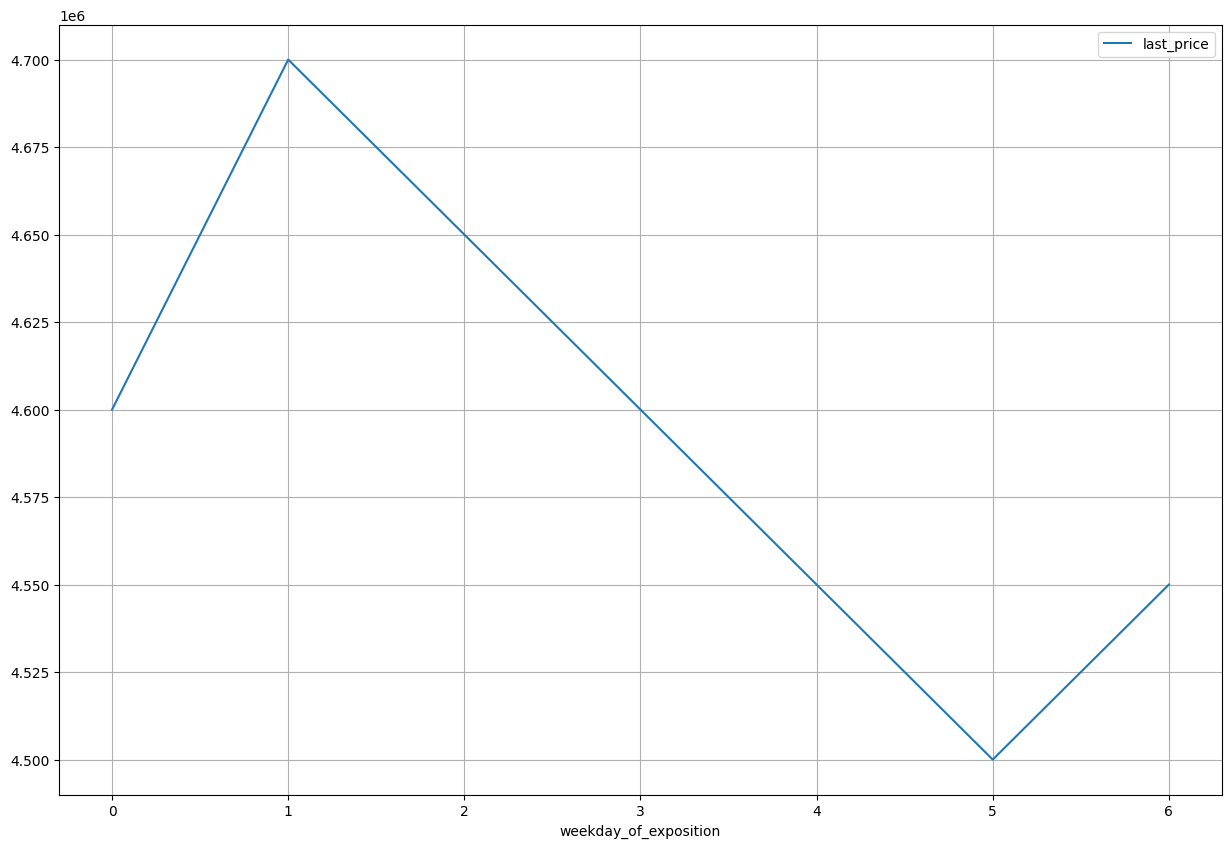

In [126]:
# Строим сводную таблицу по дню недели и медианному значению last_price
weekday_of_exposition_pivot = data.pivot_table(index='weekday_of_exposition',\
                                               values='last_price', aggfunc='median')

# Сбрасываем индексы, чтобы удобнее было работать с таблицей
weekday_of_exposition_pivot.reset_index(inplace=True)

# Строим график
weekday_of_exposition_pivot.plot(kind='line', 
                                 x='weekday_of_exposition', y='last_price', 
                                 grid=True, figsize=(15,10));



Посчитаем, на сколько процентов отличается цена в будни и выходные.

In [128]:
grouped_by_weekday = (data.groupby('weekday_of_exposition')['last_price']
                      .mean().reset_index())
mean_weekend_price = (grouped_by_weekday.loc[5,'last_price'] 
                      + grouped_by_weekday.loc[6,'last_price'])
mean_workday_price = (grouped_by_weekday.loc[0,'last_price'] + 
                      grouped_by_weekday.loc[1,'last_price'] +
                      grouped_by_weekday.loc[2,'last_price'] + 
                      grouped_by_weekday.loc[3,'last_price'] +
                      grouped_by_weekday.loc[4,'last_price'])
share_diff = mean_weekend_price*100/mean_workday_price
print(f'''Квартиры, размещенные в выходные, дешевле на {share_diff:.1f}%,
чем квартиры, размещенные в будни.''')

Квартиры, размещенные в выходные, дешевле на 38.5%,
чем квартиры, размещенные в будни.


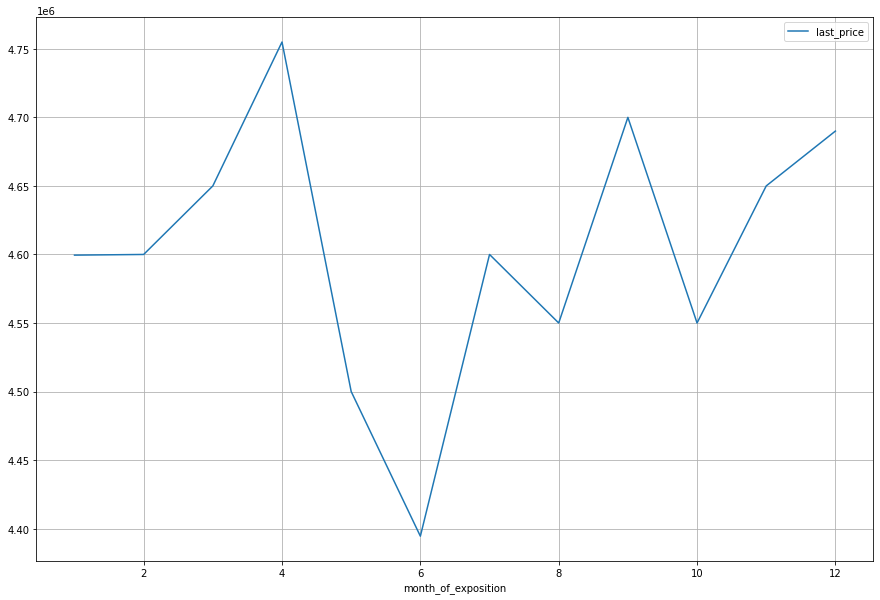

In [ ]:
# Строим сводную таблицу по месяцу размещения объявления и медианному значению last_price
month_of_exposition_pivot = data.pivot_table(index='month_of_exposition', \
                                             values='last_price', aggfunc='median')

# Сбрасываем индексы, чтобы удобнее было работать с таблицей
month_of_exposition_pivot.reset_index(inplace=True)

# Строим диаграмму рассеяния
month_of_exposition_pivot.plot(kind='line', 
                               x='month_of_exposition', y='last_price', 
                               grid=True, figsize=(15,10));


Пиковая цена приходится на апрельские объявления, а самая низкиая — на июнь.

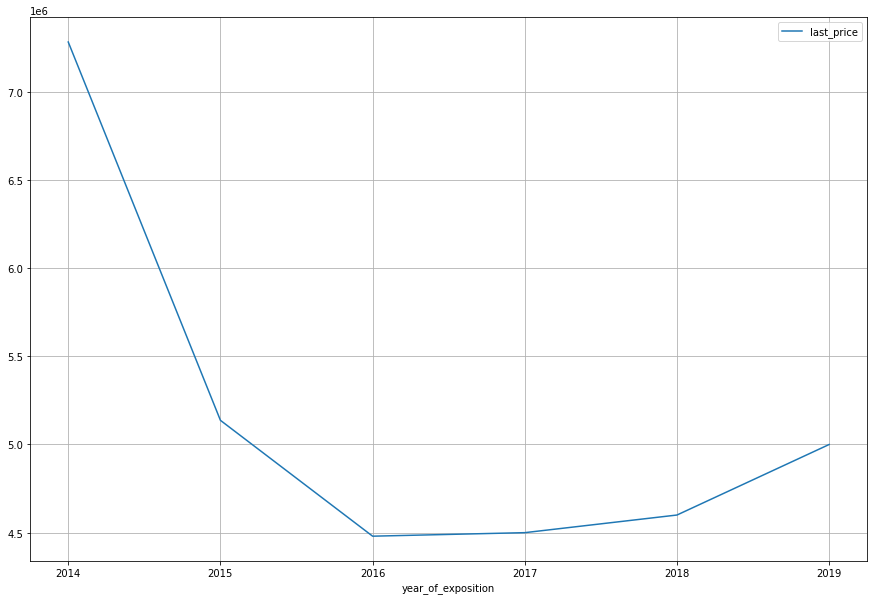

In [ ]:
# Строим сводную таблицу по году размещения объявления и медианному значению last_price
year_of_exposition_pivot = data.pivot_table(index='year_of_exposition', \
                                            values='last_price', aggfunc='median')

# Сбрасываем индексы, чтобы удобнее было работать с таблицей
year_of_exposition_pivot.reset_index(inplace=True)

# Строим диаграмму рассеяния
year_of_exposition_pivot.plot(kind='line', 
                              x='year_of_exposition', y='last_price', 
                              grid=True, figsize=(15,10));



 Посмотрим на число объявлений по годам.

In [ ]:
grouped_by_year = data.groupby('year_of_exposition')['year_of_exposition'].count()
grouped_by_year


year_of_exposition
2014     120
2015    1050
2016    2493
2017    7445
2018    7719
2019    2616
Name: year_of_exposition, dtype: int64


Как видим, с 2014 года количество объявлений растет, следовательно, нельзя ориентироваться на показатели этого года для сравнения с остальными. Посмотрим на гистограмме.

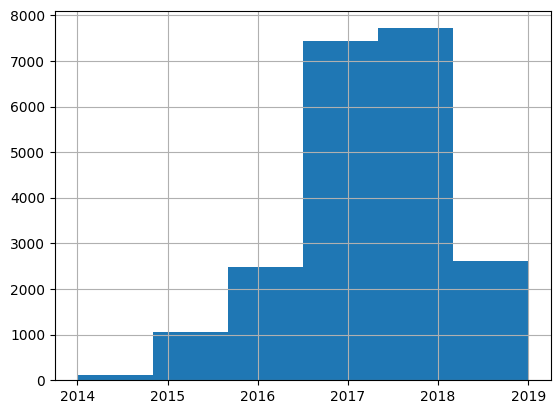

In [129]:
data['year_of_exposition'].hist(bins=6);


Посмотрим на среднюю площадь продаваемых квартир по годам.

In [130]:
year_total_area_pivot = data.pivot_table(index='year_of_exposition', 
                                         values='total_area')
year_total_area_pivot.reset_index()

,year_of_exposition,total_area
0,2014,80.422417
1,2015,64.568962
2,2016,58.947633
3,2017,57.550882
4,2018,56.256988
5,2019,56.437706


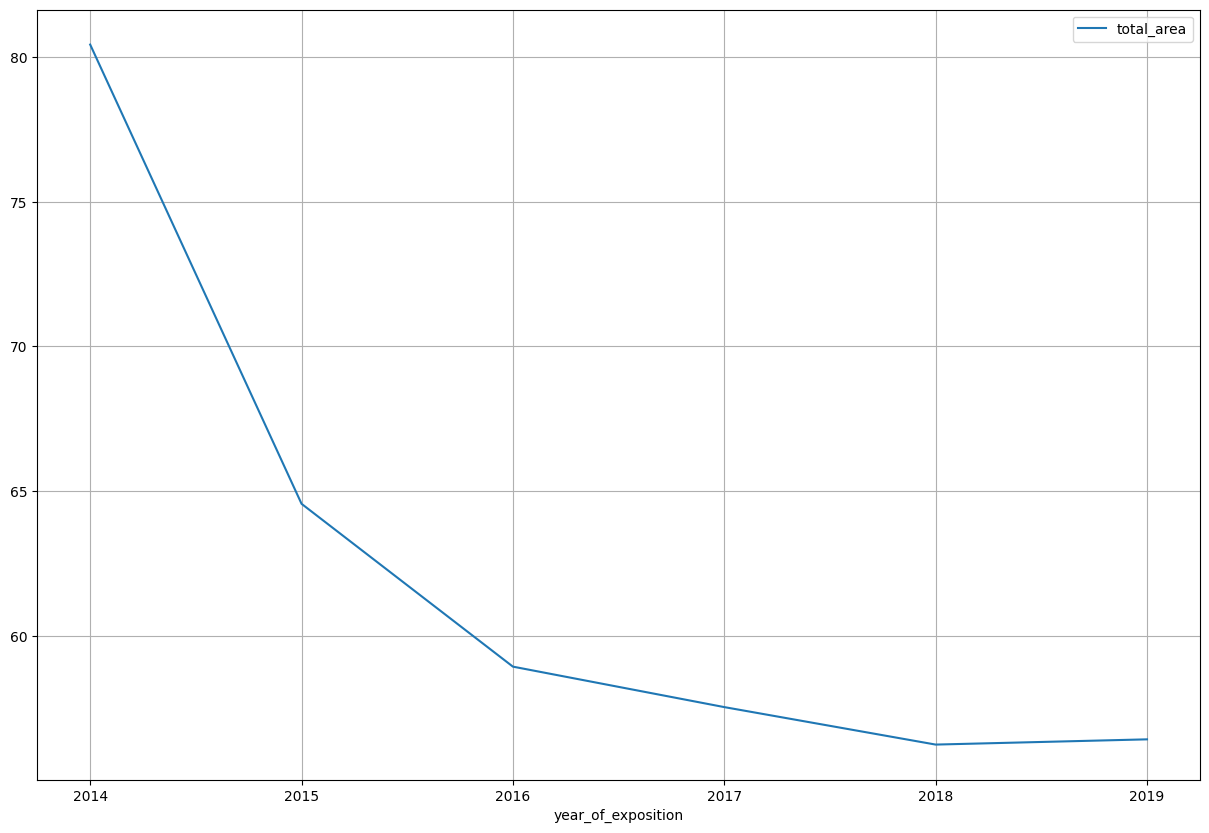

In [131]:
year_total_area_pivot.plot(kind='line',
                           y='total_area', 
                           grid=True, figsize=(15,10));



Получается, что по мере роста числа объявлений на сервисе уменьшается средняя площадь продаваемых квартир, что, вероятно, связано с тем, что растет число квартир со средними показателями площади.

**На этом этапе проекта мы выяснили:**
1. Стоимость квартиры прямо зависит от общей площади и жилой площади и в меньшей степени — от площади кухни.
2. Цены на квартиры до 5 комнат растут последовательно (чем больше комнат, тем выше цена).
3. Меньше всего стоят квартиры, расположенные на первом этаже, самые дорогие — на другом (не первый и не последний). Средний ценовой диапазон — у квартир на последнем этаже.
4. На цену квартиры влияет день публикации объявления: в пятницу и выходные активность пользователей меньше. Квартиры, размещенные со вторника по четверг, продавались в среднем по более высокой цене. В среднем квартиры, размещенные в будни, на 38,5% дороже, чем квартиры, размещенные в выходные.
5. На рынке недвижимости ярко выражена сезонность: пиковые цены — в апреле и ноябре, значительный спад — с началом лета, с дальнейшим постепенным ростом с августа.
6. Если рассматривать объявления по годам, то можно заметить, что средняя цена квартиры была выше всего в 2014 году, однако, поскольку в 2014 году было незначительное количество объявлений, этот год нельзя учитывать в сравнительном анализе. По мере роста числа объявлений на сервисе уменьшалась средняя площадь продаваемых квартир, что связано с тем, что стало больше квартир со средними показателями площади и распределение стало более равномерным.

### Cредняя цена квадратного метра в населенных пунктах с наибольшим количеством объявлений

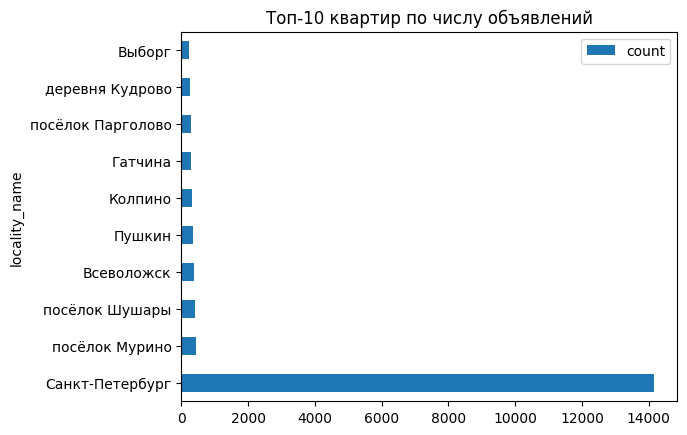

In [150]:
(
    data
    .groupby('locality_name')
    ['price_per_sqm'].agg({'count'})
    .sort_values(by = 'count', ascending = False)
    .head(10)

).plot(y = 'count', kind = 'barh')
plt.title('Топ-10 квартир по числу объявлений')
plt.show();


Мы получили график по населенным пунктам, в которых находится большая часть продаваемых квартир. На первом месте ожидаемо Санкт-Петербург. Отсортируем данные по средней цене квадратного метра.

In [140]:
(
    data
    .groupby('locality_name')['price_per_sqm']
    .agg({'count', 'mean'})
    .sort_values(by = 'count', ascending = False)
    .head(10)
    .sort_values(by = 'mean', ascending = False)

)

,mean,count
locality_name,,
Санкт-Петербург,107976.67,14152
Пушкин,102142.40,349
деревня Кудрово,91720.91,254
посёлок Парголово,89648.45,297
посёлок Мурино,84446.60,435
посёлок Шушары,77422.85,411
Колпино,75324.61,326
Гатчина,68976.22,297
Всеволожск,67089.14,365


Самая низкая цена в нашем топ-10 — в Выборге, а самая высокая — в Санкт-Петербурге, на втором месте — город Пушкин. Покажем более наглядно с помощью гистограммы.

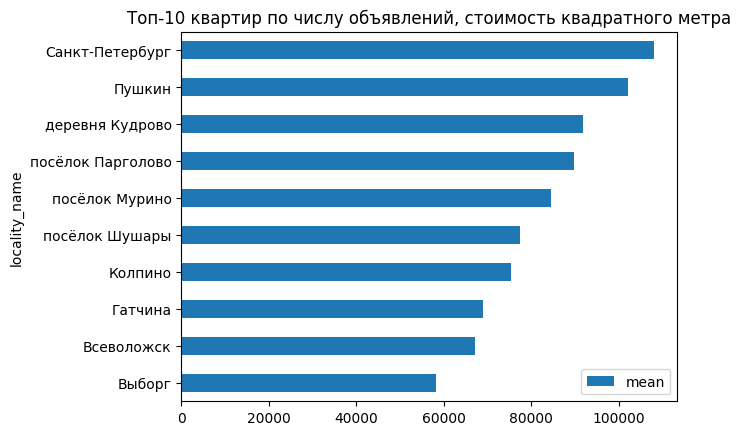

In [151]:
(
    data
    .groupby('locality_name')['price_per_sqm']
    .agg({'count', 'mean'})
    .sort_values(by = 'count', ascending = False)
    .head(10)
    .sort_values(by = 'mean', ascending = True)

).plot(y = 'mean', kind = 'barh')
plt.title('Топ-10 квартир по числу объявлений, стоимость квадратного метра')
plt.show();


### Влияние удаленности от центра города в Санкт-Перербурге на стоимость квадратного метра квартиры

In [152]:
#Строим датафрейм, где будут только квартиры в Санкт-Петербурге
flats_in_spb = data[data['locality_processed'] == 'Санкт-Петербург']

#Выбираем строки без пропусков в столбце с расстояниями до центра города
flats_in_spb = flats_in_spb[flats_in_spb['city_centers_nearest_km'].notnull()]

# Найдем среднюю цену квартиры на каждом километре
flats_in_spb['price_by_km'] = flats_in_spb.groupby('city_centers_nearest_km')['last_price'].mean()



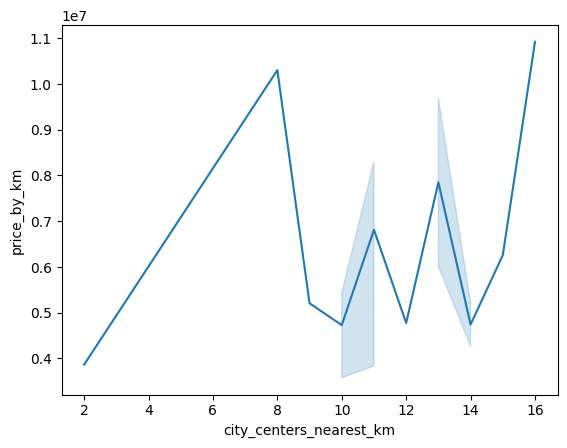

In [153]:
sns.lineplot(data=flats_in_spb, x="city_centers_nearest_km", y="price_by_km");



На графике видно, что  наибольшая средняя цена — у квартир в Санкт-Петербурге, расположенных в 8 км от центра. Для Петербурга этот радиус можно считать районами, прилегающими к центру. Далее цена падает, а затем опять растет, достигая максимума на отметке 16 км. Скорее всего, удаленность от центра влияет на цену не настолько сильно, насколько другие факторы: инфраструктура района, состояние дома, состояние квартиры, близость к метро и транспортным развязкам и пр.

## Общий вывод

1. Целью исследования было выявление закономерностей в данных и определение влияния различных параметров на стомость квартиры. Мы исследовали данные по Санкт-Петербургу и Лениградской области.


2. В ходе предобработки возникла необходимость удалить часть данных из-за наличия в них пропусков или аномальных значений. Те пропуски, которые можно было заменить средним или медианным значением без существенного искажения данных, были заполнены.


3. В ходе исследования были обнаружены следующие закономерности:
- Стоимость квартир равномерно повышается по мере роста числа комнат в квартире, эта тенденция наблюдается для квартир до пяти комнат;
- Стоимость квартиры прямо коррелирует с ее общей площадью и жилой площадью, корреляция с площадью кухни менее выражена.
- Самые дешевые квартиры расположены на первом этаже, самые дорогие — на других (не первый и не последний). 
- Цена квартиры зависит от активности пользователей в зависимости от дня недели и месяца: так, ценовой пик по дням недели наблюдается в период со вторника по четверг, а начиная с пятницы следует спад (в среднем цена на квартиры, размещенные в будние дни, на 38.5% выше, чем на квартиры, размещенные в выходные); летние цены на квартиры самые низкие, что связано с низким спросом на рынке в этот период (поскольку люди находятся в отпусках, на каникулах, на отдыхе), пиковые значения по году — в апреле и ноябре.
- В 2014 году средняя цена квартиры была выше по сравнению с 2017 году, когда был достигнут минимум по показателю средней цены, однако данные по 2014 году нерепрезентативны, поскольку объявлений на сервисе было мало. По мере роста числа объявлений снижается средняя площадь продаваемых квартир, что связано с ростом числа объявлений о квартирах средней площади и среднего ценового диапазона. Поэтому для того, чтобы проанализировать реальные цены на квартиры по годам, следует исследовать более однородные данные.


4. В ходе исследования были выделены топ-10 населенных пунктов по количеству размещенных объявлений. В этом перечне по средней цене квадратного метра лидирует Санкт-Петербург, на последнем месте по этому показателю в топ-10 — город Выборг.


5. Наибольшая средняя цена — у квартир в Санкт-Петербурге, расположенных в 8 км от центра. Для Петербурга этот радиус можно считать районами, прилегающими к центру. Далее цена падает, а затем опять растет, достигая максимума на отметке 16 км. Скорее всего, удаленность от центра влияет на цену не настолько сильно, насколько другие факторы: инфраструктура района, состояние дома, состояние квартиры, близость к метро и транспортным развязкам и пр.